In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from scipy.stats import norm
import math
from tqdm import tqdm  # Importa tqdm

from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tsa.seasonal import MSTL


# Funciones de Feature Engine
from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures
from feature_engine.imputation import DropMissingData
from feature_engine.selection import DropFeatures
from feature_engine.timeseries.forecasting import (
     LagFeatures,WindowFeatures)

# Funciones de Scikit Learn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

# Funciones de Calendario y Tiempo
import holidays
import time
from datetime import datetime
from pandas.tseries.offsets import DateOffset
from dateutil.relativedelta import relativedelta

# Funciones de Skforecast
#from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import backtesting_forecaster
#from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection import backtesting_forecaster_multiseries
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import bayesian_search_forecaster_multiseries
from skforecast.preprocessing import RollingFeatures

# Algoritmos de Machine Learning
import xgboost as xgb 
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import warnings

# Cargar Datos Historicos

In [82]:
# Función de carga 
def cargar_data(ruta):
    df = pd.read_excel(ruta)
    return df

# Preprocesar Datos Parte 1

In [77]:
def convertir_a_df_vertical(df):
    df = df.rename(columns={'CÓDIGO': 'CODIGO', 'REFERENCIA':'CLIENTE'})
    columnas_fechas = df.columns[2:]    
    # Realizar el melt para transformar el DataFrame en formato largo
    df_vertical = df.melt(
        id_vars=['CODIGO', 'CLIENTE'], 
        value_vars=columnas_fechas,
        var_name='FECHA', 
        value_name='DEMANDA'
    )
    return df_vertical

## Mapear nombre de los meses

In [78]:
# Mapear los nombres de las columnas a fechas en formato 'YYYY-MM-DD'
meses = {
    "ENE": "01", "FEB": "02", "MAR": "03", "ABR": "04", "MAY": "05", 
    "JUN": "06", "JUL": "07", "JUl":"07","AGO": "08", "SEPT": "09", "OCT": "10", 
    "NOV": "11", "DIC": "12", 
}

## Convertir Texto a Fecha

In [79]:
def convertir_texto_a_fecha(df_vertical, meses):
    # Normalizar texto en la columna 'FECHA'
    df_vertical['FECHA'] = df_vertical['FECHA'].str.upper().str.strip()

    # Extraer mes y año usando regex
    extract = df_vertical['FECHA'].str.extract(r'([A-Z]+) (\d{4})')
    extract.columns = ['mes', 'año']  # Renombrar columnas para claridad

    # Manejar valores no coincidentes
    if extract.isnull().any().any():
        no_validos = df_vertical.loc[extract.isnull().any(axis=1), 'FECHA'].unique()
        raise ValueError(f"Valores no coincidentes en 'FECHA': {no_validos}")

    # Formatear y convertir a fecha
    df_vertical['FECHA'] = pd.to_datetime(
        extract.apply(lambda x: f"{x['año']}-{meses.get(x['mes'], '01')}-01", axis=1)
    )
    
    # Establecer 'FECHA' como índice
    df_vertical_fecha = df_vertical.set_index('FECHA')
    
    return df_vertical_fecha

## Eliminar Ceros iniciales en las Series de Tiempo

In [80]:
def eliminar_ceros_iniciales(df):
    # Lista para almacenar DataFrames válidos
    lista_df = []

    # Obtener códigos únicos (SKU-cliente)
    codigos_unicos = df['CODIGO'].unique()
    clientes_unicos = df['CLIENTE'].unique()
    
    for codigo in codigos_unicos:
        for cliente in clientes_unicos:
            # Filtrar los datos para cada código y cliente
            df_codigo = df[(df['CODIGO'] == codigo) & (df['CLIENTE'] == cliente)]

            # Verificar si el DataFrame no está vacío
            if not df_codigo.empty:
                # Verificar si hay valores no cero en DEMANDA
                if df_codigo['DEMANDA'].ne(0).any():
                    # Encontrar la primera fila donde la demanda no es cero
                    indice_primer_no_cero = df_codigo['DEMANDA'].ne(0).idxmax()

                    # Recortar la serie temporal desde el primer valor no cero
                    df_codigo_recortado = df_codigo.loc[indice_primer_no_cero:]
                    
                    # Agregar a la lista si no está vacío
                    if not df_codigo_recortado.empty:
                        lista_df.append(df_codigo_recortado)

    # Concatenar todos los DataFrames válidos de una vez
    if lista_df:
        df_resultado = pd.concat(lista_df)
    else:
        df_resultado = pd.DataFrame(columns=df.columns)

    return df_resultado

# Preprocesar Datos Parte 2

In [81]:
def preprocesar_tabla_2(df_resultado):
    # Crear columna CODIGO_CLIENTE
    df_resultado['CODIGO_CLIENTE'] = df_resultado['CODIGO'] + "_" + df_resultado['CLIENTE']
    
    # Seleccionar y copiar las columnas relevantes
    df_mes_cliente = df_resultado[['CODIGO_CLIENTE', 'CODIGO', 'CLIENTE', 'DEMANDA']].copy()
    
    return df_mes_cliente

## Grafica Demanda Original por Cliente

In [9]:
def graficar_demanda_codigo_cliente(df_mes_cliente):
    # Obtener los códigos únicos
    codigos_unicos = df_mes_cliente['CODIGO'].unique()
    
    # Crear la figura de subplots
    fig = make_subplots(
        rows=(len(codigos_unicos) + 2) // 3,  # Para distribuir los subplots en 3 columnas
        cols=3,
        shared_yaxes=False,  # No Compartir el eje Y
        subplot_titles=[f"Código: {codigo}" for codigo in codigos_unicos],
        vertical_spacing=0.018,  # Reducir el espaciado vertical entre los subplots
    )
    
    # Colores específicos para clientes
    cliente_colores = {
        'NOVAVENTA': '#FFA500',  # Naranja
        'DISTRIBUIDORES': "#4682B4",  # Azul Acero
    }
    
    # Asignar un color único para los otros clientes, si los hay
    clientes_unicos = df_mes_cliente['CLIENTE'].unique()
    for i, cliente in enumerate(clientes_unicos):
        if cliente not in cliente_colores:
            # Asignar un color diferente para los otros clientes
            cliente_colores[cliente] = f"rgb({(i * 50) % 256}, {(i * 100) % 256}, {(i * 150) % 256})"
    
    # Iterar sobre cada código para agregar los subplots
    for i, codigo in enumerate(codigos_unicos, start=1):
        # Filtrar los datos para el código actual
        df_codigo = df_mes_cliente[df_mes_cliente['CODIGO'] == codigo]
        
        # Iterar sobre los clientes y agregar una traza por cliente
        for cliente in clientes_unicos:
            df_cliente = df_codigo[df_codigo['CLIENTE'] == cliente]
            fig.add_trace(
                go.Scatter(
                    x=df_cliente.index,  # Usar el índice de fecha
                    y=df_cliente['DEMANDA'],
                    mode='lines',
                    name=cliente,
                    line=dict(color=cliente_colores[cliente]),  # Asignar color específico por cliente
                ),
                row=(i - 1) // 3 + 1,  # Fila en la que estará el subplot
                col=(i - 1) % 3 + 1,   # Columna en la que estará el subplot
            )
    
    # Ajustar la altura total para todos los subplots y actualizar la disposición
    fig.update_layout(
        height=220 * ((len(codigos_unicos) + 2) // 3),  # Aumentar la altura total de los subplots
        title_text="Demanda por Código y Cliente",
        title_x=0.5,  # Centrar el título
        title_font=dict(size=14),  # Tamaño de fuente del título principal
        showlegend=False,  # Eliminar la leyenda
        font=dict(size=10),  # Tamaño de fuente general
        margin=dict(l=50, r=50, t=50, b=50),  # Ajustar márgenes
        template="ggplot2",
#        xaxis=dict(tickformat="%Y-%m-%d"),  # Formato de la fecha
#        xaxis_rangeslider_visible=False,  # Quitar el rango deslizante en el eje X
    )
        # Ajustar los títulos de los subplots
    for annotation in fig['layout']['annotations']:
        annotation['font'] = dict(size=11)  # Reducir tamaño del texto de los títulos de subplots
        
     # Ajustar los títulos de los subplots y ejes
    fig.update_xaxes(title_font=dict(size=9))  # Tamaño de fuente para los títulos del eje X
    fig.update_yaxes(title_font=dict(size=9))  # Tamaño de fuente para los títulos del eje Y
    # Mostrar la figura
    fig.show()


## Consolidar Demanda por Codigo

In [84]:
def agrupar_demanda(df_mes_cliente):
    # Agrupar por FECHA y CÓDIGO, sumar DEMANDA
    df_mes_orig = (
        df_mes_cliente
        .groupby(['FECHA', 'CODIGO'])
        .agg({'DEMANDA': 'sum'})
        .reset_index()
        .set_index('FECHA')
    )
    
    # Calcular el largo de cada serie de tiempo por CODIGO
    series_length = df_mes_orig.groupby('CODIGO').size()
    
    # Filtrar los códigos con menos de 2 registros
    codigos_cortos = series_length[series_length < 2].index.tolist()
    
    # Generar un reporte de estos códigos
    reporte_codigos = df_mes_orig[df_mes_orig['CODIGO'].isin(codigos_cortos)]
    
    # Eliminar los códigos con menos de 2 registros del DataFrame original
    df_mes_orig = df_mes_orig[~df_mes_orig['CODIGO'].isin(codigos_cortos)]

    print('No se pronosticaran las siguientes referencias debido a que tienen muy pocos datos:')
    print(reporte_codigos.groupby('CODIGO').size())
    
    return df_mes_orig, reporte_codigos

## Grafica Consolidada por Codigo

In [85]:
def graficar_demanda_codigo(df_mes_orig):
    # Obtener los códigos únicos
    codigos_unicos = df_mes_orig['CODIGO'].unique()
    
    # Crear la figura de subplots
    fig = make_subplots(
        rows=(len(codigos_unicos) + 2) // 3,  # Distribuir en 3 columnas
        cols=3,
        shared_yaxes=False,  # No compartir el eje Y
        subplot_titles=[f"Código: {codigo}" for codigo in codigos_unicos],
        vertical_spacing=0.009,  # Reducir el espaciado entre subplots
    )
    
    # Iterar sobre cada código para agregar subplots
    for i, codigo in enumerate(codigos_unicos, start=1):
        # Filtrar los datos para el código actual
        df_codigo = df_mes_orig[df_mes_orig['CODIGO'] == codigo]
        
        # Agregar una traza al subplot
        fig.add_trace(
            go.Scatter(
                x=df_codigo.index,  # Usar el índice de fecha
                y=df_codigo['DEMANDA'],
                mode='lines',
                name=codigo,
                line=dict(width=2, color = "#4682B4"),  # Personalizar el ancho de la línea
            ),
            row=(i - 1) // 3 + 1,  # Fila en la que estará el subplot
            col=(i - 1) % 3 + 1,   # Columna en la que estará el subplot
        )
    
    # Ajustar el diseño general
    fig.update_layout(
        height=220 * ((len(codigos_unicos) + 2) // 3),  # Altura ajustada según el número de subplots        
        title_text="Demanda por Código",
        title_x=0.5,  # Centrar el título
        title_font=dict(size=14),  # Tamaño de fuente del título principal
        showlegend=False,  # Eliminar la leyenda global
        font=dict(size=10),  # Tamaño de fuente general
        margin=dict(l=50, r=50, t=50, b=50),  # Ajustar márgenes
        template="ggplot2",
    )
    # Ajustar los títulos de los subplots
    for annotation in fig['layout']['annotations']:
        annotation['font'] = dict(size=11)  # Reducir tamaño del texto de los títulos de subplots
        
     # Ajustar los títulos de los subplots y ejes
    fig.update_xaxes(title_font=dict(size=9))  # Tamaño de fuente para los títulos del eje X
    fig.update_yaxes(title_font=dict(size=9))  # Tamaño de fuente para los títulos del eje Y
    # Mostrar la figura
    fig.show()

In [86]:
def preprocesar_demanda_cliente(df_mes_cliente):
    df_mes_orig = df_mes_cliente.copy()
    df_mes_orig = df_mes_orig.drop(columns=['CODIGO','CLIENTE'])
    df_mes_orig = df_mes_orig.rename(columns={'CODIGO_CLIENTE':'CODIGO'})
    # Calcular el largo de cada serie de tiempo por CODIGO
    series_length = df_mes_orig.groupby('CODIGO').size()
    
    # Filtrar los códigos con menos de 2 registros
    codigos_cortos = series_length[series_length < 2].index.tolist()
    
    # Generar un reporte de estos códigos
    reporte_codigos = df_mes_orig[df_mes_orig['CODIGO'].isin(codigos_cortos)]
    
    # Eliminar los códigos con menos de 2 registros del DataFrame original
    df_mes_orig = df_mes_orig[~df_mes_orig['CODIGO'].isin(codigos_cortos)]

    print('No se pronosticaran las siguientes referencias debido a que tienen muy pocos datos:')
    print(reporte_codigos.groupby('CODIGO').size())

    return df_mes_orig, reporte_codigos

In [87]:
opciones = ['POR_CODIGO_CLIENTE','POR_CODIGO_AGREGADO']
def seleccionar_tipo_pronostico(opcion, df_mes_cliente):
    if opcion == 'POR_CODIGO_CLIENTE':
        df_mes_orig, reporte_codigos = preprocesar_demanda_cliente(df_mes_cliente)
    elif opcion == 'POR_CODIGO_AGREGADO':
        df_mes_orig, reporte_codigos = agrupar_demanda(df_mes_cliente)
    
    return df_mes_orig, reporte_codigos

## Reemplazar los ceros por la mediana

In [17]:
def reemplazar_ceros(df_mes_orig):
    
    # Generar copia de trabajo
    df_mes_ceros = df_mes_orig.copy()
    # Reemplazar los valores de demanda iguales a 0 por la mediana correspondiente
    # df_mes_ceros['DEMANDA'] = df_mes_orig.groupby('CODIGO')['DEMANDA'].transform(
    #     lambda x: x.replace(0, x.median())
    #     )
    df_mes_ceros['DEMANDA'] = df_mes_orig.groupby('CODIGO')['DEMANDA'].transform(
        lambda x: x.where(x >= 70, x.median())
    )
    return df_mes_ceros

## Imputar Outliers con Lim Sup - Lim Inf

* Se crea un pronostico con n=6, para los primeros periodos se va promediando los datos disponibles hasta que tenga 6 datos
* Se definen limites superior e inferior con base en la distribucion normal, 98% y 2% (ajustable)
* Se aplica distribucion normal, lo que quede por fuera de limites se marca como outlier, se recalcula promedio y desviacion
* Se establece lim_sup como pronostico + percentil 98% y lim_inf como pronostico - percentil 2%

In [88]:
def imputar_outliers(df_outliers, sup, inf, n):
    
    # Generar un pronostico Ingenuo
    df_outliers['FORECAST'] = df_outliers['DEMANDA'].rolling(window=n, min_periods=1).mean().shift(1)
    
    # Calcular la mediana de la columna DEMANDA
    mediana_demanda = df_outliers['DEMANDA'].median()
    
    # Reemplazar los valores NaN en la columna FORECAST con la mediana de DEMANDA
    df_outliers['FORECAST'] = df_outliers['FORECAST'].fillna(mediana_demanda)

    # Calular error
    df_outliers['ERROR'] = df_outliers['DEMANDA'] - df_outliers['FORECAST']

    # Calcular Promedio y desviacion
    m = df_outliers['ERROR'].mean()
    s = df_outliers['ERROR'].std()

    # Aplicar Percentil sup e inf
    prob = norm.cdf(df_outliers['ERROR'],m,s)

    # Marcar principales Outliers
    outliers = (prob > sup) | (prob < inf)

    # Recalcular promedio y desviacion SIN principales outliers
    m2 = df_outliers.loc[~outliers,'ERROR'].mean()
    s2 = df_outliers.loc[~outliers,'ERROR'].std()

    # Calcular limite superior e inferior
    df_outliers['LIM_SUP'] = norm.ppf(sup,m2,s2) + df_outliers['FORECAST']
    df_outliers['LIM_INF'] = norm.ppf(inf,m2,s2) + df_outliers['FORECAST']

    # Usar .clip para imputar los valores por fuera de los limites
    df_outliers['NUEVA_DEM'] = df_outliers['DEMANDA'].clip(lower = df_outliers['LIM_INF'], upper= df_outliers['LIM_SUP'])

    # Señalar los valores imputados
    df_outliers['IS_OUTLIER'] = (df_outliers['DEMANDA'] != df_outliers['NUEVA_DEM'])
    
    return df_outliers
    


In [90]:
def eliminar_outliers(df_mes_ceros, sup, inf, n):
    
    # Inicializar el DataFrame acumulado vacío
    df_acumulado = pd.DataFrame()
    # Aplicar la función imputar_outliers a cada grupo (SKU)
    for sku, df_sku in df_mes_ceros.groupby('CODIGO'):
        # Asegurarse de que 'FECHA' sea el índice
        
        # Imputar outliers para cada SKU
        df_imputado = imputar_outliers(df_sku.copy(), sup, inf, n)
        
        # Agregar el resultado al DataFrame acumulado
        df_acumulado = pd.concat([df_acumulado, df_imputado])
    df_outliers = df_acumulado.copy()
    df_acumulado = df_acumulado[['CODIGO',	
                                 #'REFERENCIA', 
                                 'NUEVA_DEM']]
    df_mes = df_acumulado.rename(columns={'NUEVA_DEM':'DEMANDA'})
    # Mostrar el DataFrame acumulado
    return df_mes, df_outliers

In [21]:
#outliers = df_outliers[df_outliers['IS_OUTLIER'] == True]
#outliers.to_excel('outliers.xlsx')

In [91]:
def graficar_outliers_subplots(df_mes_ceros, sup, inf, n):
    # Lista de SKUs únicos
    lista_skus = df_mes_ceros['CODIGO'].unique()
    
    # Calcular número de filas necesarias para 3 columnas
    n_cols = 3
    n_rows = -(-len(lista_skus) // n_cols)  # Redondeo hacia arriba

    # Crear los subplots
    fig = make_subplots(
        rows=n_rows, cols=n_cols,
        subplot_titles=[f"SKU: {sku}" for sku in lista_skus],
        horizontal_spacing=0.05,
        vertical_spacing=0.008
    )
    
    # Definir colores
    color_demanda = "#FF6347"  # Rojo tomate
    color_forecast = "#FFA500"  # Naranja
    color_nueva_dem = "#4682B4" # Azul Acero
    
    # Iterar por cada SKU
    for idx, sku in enumerate(lista_skus):
        # Filtrar por SKU
        df_outliers = df_mes_ceros[df_mes_ceros['CODIGO'] == sku][['DEMANDA']].copy()

        # Aplicar función imputar_outliers
        df_outliers = imputar_outliers(df_outliers, sup, inf, n)

        # Calcular la posición en la cuadrícula
        row = (idx // n_cols) + 1
        col = (idx % n_cols) + 1

        # Agregar trazas al subplot
        fig.add_trace(go.Scatter(
            x=df_outliers.index,
            y=df_outliers["DEMANDA"],
            name=f"Demanda - {sku}",
            mode='lines',
            marker=dict(size=6),
            line=dict(width=2, color=color_demanda)
        ), row=row, col=col)

        fig.add_trace(go.Scatter(
            x=df_outliers.index,
            y=df_outliers["FORECAST"],
            mode='lines',
            name=f"Forecast - {sku}",
            marker=dict(size=6),
            line=dict(width=2.2, dash='solid', color=color_forecast)
        ), row=row, col=col)

        fig.add_trace(go.Scatter(
            x=df_outliers.index,
            y=df_outliers["NUEVA_DEM"],
            mode='lines',
            name=f"Nueva Demanda - {sku}",
            marker=dict(size=6),
            line=dict(width=2, dash='solid', color=color_nueva_dem)
        ), row=row, col=col)

        # Límites superior e inferior
        fig.add_trace(go.Scatter(
            x=df_outliers.index,
            y=df_outliers["LIM_SUP"],
            mode='lines',
            name=f"Límite Superior - {sku}",
            line=dict(color='black', width=1, dash='dot'),
            opacity=0.5
        ), row=row, col=col)

        fig.add_trace(go.Scatter(
            x=df_outliers.index,
            y=df_outliers["LIM_INF"],
            mode='lines',
            name=f"Límite Inferior - {sku}",
            line=dict(color='black', width=1, dash='dot'),
            opacity=0.5
        ), row=row, col=col)

        # Outliers
        if df_outliers["IS_OUTLIER"].any():
            fig.add_trace(go.Scatter(
                x=df_outliers.index[df_outliers["IS_OUTLIER"]],
                y=df_outliers["DEMANDA"].loc[df_outliers["IS_OUTLIER"]],
                mode='markers',
                name=f"Outliers - {sku}",
                marker=dict(color=color_demanda, size=8, symbol='circle')
            ), row=row, col=col)

    # Actualizar diseño global
    fig.update_layout(
        title="Outliers vs Ventas por SKU",
        title_x=0.5,  # Centrar el título
        title_font=dict(size=14),  # Tamaño de fuente del título principal
        font=dict(size=10),  # Tamaño de fuente general
        margin=dict(l=50, r=50, t=50, b=50),  # Ajustar márgenes
        template="ggplot2",
        height=200 * n_rows,  # Ajustar altura según filas
        #width=900,  # Ancho fijo
        showlegend=False  # Ocultar leyenda global
    )
    for annotation in fig['layout']['annotations']:
        annotation['font'] = dict(size=11)  # Reducir tamaño del texto de los títulos de subplots
        
    # Mostrar la figura
    fig.show()

# Funciones generales de ayuda para procesar modelos

## Funcion para crear la lista de sku's

In [92]:
def crear_lista_skus(df_mes):
    lista_skus = df_mes['CODIGO'].unique()
    return lista_skus

## Funcion para calcular el numero de meses a evaluar por cada SKU

In [93]:
def calcular_meses_a_evaluar(df_sku, periodo_max_evaluacion, porc_eval):
       
    #Calculo del largo de cada serie de tiempo
    largo_serie_tiempo = len(df_sku)
    
    # Calculo del numero de meses a usar como testeo de acuerdo con porc_eval
    meses_evaluar = min(periodo_max_evaluacion, math.ceil(largo_serie_tiempo * porc_eval))

    return meses_evaluar

## Funcion para crear el rango de fechas para iterar

In [94]:
def crear_rango_fechas(df_sku, meses_evaluar):
    
    # Seleccionar la fecha mas reciente de los datos originales
    ultima_fecha = df_sku.index.max()
    
    # Definimos la fecha inicial de corte - meses_evaluar -1 
    inicio = ultima_fecha - pd.DateOffset(months=meses_evaluar)
  
    # Creamos un rango de fechas comenzando en inicio y terminando en ultina_fecha, con frecuencia mensual inicio MS
    rango_fechas = pd.date_range(start=inicio, end=ultima_fecha, freq='MS')
   
    #print(f'Los meses a evaluar son: {len(rango_fechas)}')
    
    #print(rango_fechas)

    return rango_fechas

## Funciones para calculo y medicion de metricas de error

### Función para crear columnas de error, error absoluto, error porcentual y error cuadrado

In [95]:
def crear_columnas_error(df):
    
    df['ERROR'] = df['DEMANDA'] - df['FORECAST'] # Error
    df['ABS_ERROR'] = df['ERROR'].abs() # Error Absoluto
    df['ERROR_PORC'] = np.where(df['DEMANDA'] == 0, 2, df['ABS_ERROR'] / df['DEMANDA']) # Error porcentual, devuelve 200% si la demanda es 0
    df['ERROR_CUADRADO'] = df['ERROR'] ** 2 # Error al cuadrado
    
    return df

### Funcion para calcular las metricas totales dado un df con columnas de error

In [96]:
def metricas_error(df):
     
    # Verificar si el total de la demanda es 0
    if df['DEMANDA'].sum() == 0:
        sesgo_porc = 2
        mae_porc = 2
        score = 2
    else:
        sesgo_porc = df['ERROR'].sum() / df['DEMANDA'].sum()
        mae_porc = df['ABS_ERROR'].sum() / df['DEMANDA'].sum()
        score = mae_porc + abs(sesgo_porc)
    
    rmse = np.sqrt(df['ERROR_CUADRADO'].mean())

    return sesgo_porc, mae_porc, rmse, score

### Funcion para calcular metricas de error globales para un modelo

In [97]:
def calcular_error_global(df):

    # Calcula las diferente metricas
    mae_global = df['ABS_ERROR'].sum()/df['DEMANDA'].sum()
    sesgo_global = df['ERROR'].sum()/df['DEMANDA'].sum()
    score_global = mae_global + abs(sesgo_global)
    rmse_global = np.sqrt((df['ERROR_CUADRADO']).sum() / df['ERROR'].size)
    
    # Muestra los resultados formateados
    print('MAE% global: {:.2%}'.format(mae_global))
    print('Sesgo% global: {:.2%}'.format(sesgo_global))
    print('Score global: {:.2%}'.format(score_global))
    print('RMSE global: {:.1f}'.format(rmse_global))

    return mae_global, sesgo_global, score_global, rmse_global

In [98]:
def kpi_error_sku(df):
    
    fecha_fin_testeo = df.index.max()
    fecha_inicio_testeo = df.index.min()
       
    df_test = crear_columnas_error(df)
    print('Periodo de Evaluacion desde:')
    print(f"\033[1m{df_test.index.min().strftime('%Y-%m')} hasta {df_test.index.max().strftime('%Y-%m')}\033[0m") #\033[1m{}\033[0m muestra la linea en negrilla
    mae_global, sesgo_global, score_global, rmse_global=calcular_error_global(df_test)
    
    # Agrupar df por sku
    grupo_sku_error = df_test.groupby(['CODIGO'], observed=True).agg({
                                                            'DEMANDA': 'sum',
                                                            'ERROR': 'sum',
                                                            'ABS_ERROR': 'sum',
                                                            'ERROR_CUADRADO': ['sum', 'count'],
                                                            }).reset_index()
    grupo_sku_error.columns = ['CODIGO', 'DEMANDA', 'ERROR', 'ABS_ERROR', 
                             'ERROR_CUADRADO_suma', 'ERROR_CUADRADO_cuenta']
    # Calcular MAE% y Sesgo% de datos agregados por sku
    grupo_sku_error = calcular_error(grupo_sku_error)
    
    # Ordenar el DataFrame por 'SCORE%' en orden ascendente
    grupo_sku_error = grupo_sku_error.sort_values(by='SCORE%')
    
    # Aplicar formato porcentaje
    formatted_columns = grupo_sku_error[['MAE%', 'SESGO%', 'SCORE%']].map(lambda x: f'{x * 100:.2f}%')
    
    # Concatenar la columna "Codigo" sin formatear con las columnas formateadas
    grupo_sku_error_formato = pd.concat([grupo_sku_error[['CODIGO']], formatted_columns], axis=1)
    
    # Mostrar el resultado
    display(grupo_sku_error_formato)

    # Agrupar por codigo y por Lag para almacenar RMSE
    grupo_sku_lag_error = df_test.groupby(['CODIGO', 'LAG'], observed=True).agg({
                                                            'DEMANDA': 'sum',
                                                            'ERROR': 'sum',
                                                            'ABS_ERROR': 'sum',
                                                            'ERROR_CUADRADO': ['sum', 'count'],
                                                            }).reset_index()
    
    grupo_sku_lag_error.columns = ['CODIGO','LAG', 'DEMANDA', 'ERROR', 'ABS_ERROR', 
                             'ERROR_CUADRADO_suma', 'ERROR_CUADRADO_cuenta']
    
    grupo_sku_lag_error = calcular_error(grupo_sku_lag_error)
    
    rmse_sku_lag = grupo_sku_lag_error[['CODIGO','LAG','RMSE']]
    
    # Agrupar por codigo y por Mes para almacenar RMSE
    df_test['Mes'] = df_test.index.month
    grupo_sku_mes_error = df_test.groupby(['CODIGO', 'Mes'], observed=True).agg({
                                                            'DEMANDA': 'sum',
                                                            'ERROR': 'sum',
                                                            'ABS_ERROR': 'sum',
                                                            'ERROR_CUADRADO': ['sum', 'count'],
                                                            }).reset_index()
    grupo_sku_mes_error.columns = ['CODIGO','Mes', 'DEMANDA', 'ERROR', 'ABS_ERROR', 
                             'ERROR_CUADRADO_suma', 'ERROR_CUADRADO_cuenta']
    
    grupo_sku_mes_error = calcular_error(grupo_sku_mes_error)
    
    rmse_sku_mes = grupo_sku_mes_error[['CODIGO','Mes','RMSE']]
    
    return grupo_sku_error_formato, rmse_sku_lag, rmse_sku_mes

### Funcion para calcular metricas por una sola linea

In [99]:
def calcular_error(df):
    df['MAE%'] = df['ABS_ERROR']/df['DEMANDA']
    df['SESGO%'] = df['ERROR']/df['DEMANDA']
    df['SCORE%'] = df['MAE%'] + df['SESGO%'].abs()
    if 'ERROR_CUADRADO_suma' in df.columns:
        df['RMSE'] = np.sqrt(df['ERROR_CUADRADO_suma'] / df['ERROR_CUADRADO_cuenta'])
    return df

### Funcion para calcular errores por LAG

In [100]:
def evaluar_lags(df):
    # Calcular los scores por lag
    df_lags = df.groupby('LAG')[['ERROR', 'ABS_ERROR', 'DEMANDA']].sum()
        
    # Calcular los scores por lag evitando la división cuando DEMANDA es cero                  
    df_lags['SCORE%'] = np.where(df_lags['DEMANDA'] == 0, 2,
                            (df_lags['ABS_ERROR'] / df_lags['DEMANDA']) + abs(df_lags['ERROR'] / df_lags['DEMANDA'])
                            )
    return df_lags

In [101]:
def kpi_error_lag(df):
    
    fecha_fin_testeo = df.index.max()
    fecha_inicio_testeo = df.index.min()
    
      
    df_test = crear_columnas_error(df)
    print('Periodo de Evaluacion desde:')   
    print(f"\033[1m{df_test.index.min().strftime('%Y-%m')} hasta {df_test.index.max().strftime('%Y-%m')}\033[0m") #\033[1m{}\033[0m muestra la linea en negrilla
    mae_global, sesgo_global, score_global, rmse_global=calcular_error_global(df_test)
    # Agrupar df por mes
    grupo_mes_error = df_test.groupby(['LAG']).agg({
                                                            'DEMANDA': 'sum',
                                                            'ERROR': 'sum',
                                                            'ABS_ERROR': 'sum',
                                                            'ERROR_CUADRADO': ['sum', 'count'],
                                                            }).reset_index()
    grupo_mes_error.columns = ['LAG', 'DEMANDA', 'ERROR', 'ABS_ERROR', 
                             'ERROR_CUADRADO_suma', 'ERROR_CUADRADO_cuenta']
    # Calcular MAE% y Sesgo% de datos agregados por mes
    grupo_mes_error = calcular_error(grupo_mes_error)
    # Aplicar formato porcentaje
    formatted_columns = grupo_mes_error[['MAE%', 'SESGO%', 'SCORE%']].map(lambda x: f'{x * 100:.2f}%')
    
    # Concatenar la columna "Lag" sin formatear con las columnas formateadas
    grupo_mes_error_formato = pd.concat([grupo_mes_error[['LAG']], formatted_columns], axis=1)
    
    # Mostrar el resultado
    display(grupo_mes_error_formato)

    # Agrupar por codigo y por Lag para almacenar RMSE
    grupo_sku_lag_error = df_test.groupby(['CODIGO', 'LAG'], observed=True).agg({
                                                            'DEMANDA': 'sum',
                                                            'ERROR': 'sum',
                                                            'ABS_ERROR': 'sum',
                                                            'ERROR_CUADRADO': ['sum', 'count'],
                                                            }).reset_index()
    grupo_sku_lag_error.columns = ['CODIGO', 'LAG', 'DEMANDA', 'ERROR', 'ABS_ERROR', 
                             'ERROR_CUADRADO_suma', 'ERROR_CUADRADO_cuenta']
    
    grupo_sku_lag_error = calcular_error(grupo_sku_lag_error)
    rmse_sku_lag = grupo_sku_lag_error[['CODIGO', 'LAG','RMSE']]

    
    return grupo_mes_error_formato, df_test

In [102]:
# Agrupar df por sku
def agrupar_por_codigo(df):
    grupo_sku_error = df.groupby(['CODIGO'], observed=True).agg({
                                                                'DEMANDA': 'sum',
                                                                'ERROR': 'sum',
                                                                'ABS_ERROR': 'sum',
                                                                'ERROR_CUADRADO': ['sum', 'count'],
                                                                }).reset_index()
    grupo_sku_error.columns = ['CODIGO', 'DEMANDA', 'ERROR', 'ABS_ERROR', 
                                 'ERROR_CUADRADO_suma', 'ERROR_CUADRADO_cuenta']
        # Calcular MAE% y Sesgo% de datos agregados por sku
    grupo_sku_error = calcular_error(grupo_sku_error)
    grupo_sku_error = grupo_sku_error[['CODIGO','MAE%',	'SESGO%',	'SCORE%',	'RMSE']]
    
    # Agrupar por codigo y por Lag 
    grupo_sku_lag_error = df.groupby(['CODIGO', 'LAG'], observed=True).agg({
                                                            'DEMANDA': 'sum',
                                                            'ERROR': 'sum',
                                                            'ABS_ERROR': 'sum',
                                                            'ERROR_CUADRADO': ['sum', 'count'],
                                                            }).reset_index()
    
    grupo_sku_lag_error.columns = ['CODIGO','LAG', 'DEMANDA', 'ERROR', 'ABS_ERROR', 
                             'ERROR_CUADRADO_suma', 'ERROR_CUADRADO_cuenta']
    
    grupo_sku_lag_error = calcular_error(grupo_sku_lag_error)
    grupo_sku_lag_error = grupo_sku_lag_error[['CODIGO','LAG','MAE%',	'SESGO%',	'SCORE%',	'RMSE']]

    # Pivotear el DataFrame de lag
    pivoted_lags = grupo_sku_lag_error.pivot(index='CODIGO', columns='LAG', values='SCORE%')
    pivoted_lags.columns = [f"score_{col}" for col in pivoted_lags.columns]
    
    # Unir con el DataFrame principal
    tabla_final = grupo_sku_error.merge(pivoted_lags, on='CODIGO', how='left')
    
    # Renombrar columnas para cumplir con el formato
    tabla_final = tabla_final.rename(columns={'MAE%': 'mae_porc', 'SESGO%': 'sesgo_porc', 'SCORE%': 'score', 'RMSE': 'rmse'})
    
    return tabla_final

## Funciones para formatear y graficar

### Funcion para construir pronostico final para el promedio movil simple

In [103]:
def construir_pronostico_pms(df_mejor, df_mes, meses_a_pronosticar_produccion, nombre_modelo):

    # Crear un nuevo DataFrame para almacenar los resultados
    data = []
    
    # Iterar por cada fila de df_mejor
    for _, row in df_mejor.iterrows():
        codigo = row["CODIGO"]
        ultimo_forecast = row["ultimo_forecast"]
        # Generar las fechas para los meses pronosticados
        fechas = [df_mes.index.max() + pd.DateOffset(months=i) for i in range(1, meses_a_pronosticar_produccion + 1)]
    
        # Generar las filas para los meses pronosticados
        for i, fecha in enumerate(fechas, start=1):
            data.append({
                "FECHA": fecha,
                "CODIGO": codigo,
                "FORECAST": ultimo_forecast,
                "LAG": f"Lag_{i}"
            })
    
    # Crear el nuevo DataFrame
    df_forecast = pd.DataFrame(data)
    df_forecast = df_forecast.set_index('FECHA')
    df_forecast['MODELO'] = nombre_modelo
    
    # Visualizar el resultado
    return df_forecast

### Funcion para adicionar nombre del modelo

In [104]:
def adicionar_nombre_modelo_serie_tiempo(df, nombre_modelo):
    df['MODELO'] = nombre_modelo
    df = df[['CODIGO','FORECAST','LAG','MODELO']]
    df.index.name = 'FECHA'
    return df

# Modelos de Pronosticos de Series de Tiempo

## Simulacion promedio movil simple PMS

Evalúa y genera pronósticos PMS para un grupo de SKUs, seleccionando el mejor n con base en el score.

Args:
* df_mes (DataFrame): DataFrame con datos de demanda imputando outliers por SKU.
* df_mes_ceros (Data Frame): DataFrame con datos de demanda original (sin imputar outliers), pero con ceros reemplazados por la mediana
* lista_skus (list): Lista de SKUs a evaluar.
* periodo_max_evaluacion (int): Máximo numero de meses a evaluar - se mantendra en 12.
* porc_eval (float): Porcentaje de datos (meses) a usar para evaluación.
* meses_a_pronosticar_evaluacion (int): Número de meses a pronosticar para efectos de seleccion de modelo

Devuelve:
* DataFrame df_mejor_n: Información del mejor n, metricas, pronostico por SKU.
* DataFrame df_forecast_pms: Datos de pronósticos seleccionados.


In [105]:
def evaluar_y_generar_pms(df_mes, df_mes_ceros, lista_skus, periodo_max_evaluacion, porc_eval, meses_a_pronosticar_evaluacion):
    
    mejor_n = [] # Bolsa para guardar resultados por cada sku
    acumulado_forecast = [] # Bolsa para guardar los resultados de todos los pronosticos
        
    for sku in tqdm(lista_skus, desc="Procesando SKUs"):
    
        resultados_n = [] # Bolsa para guardar resultados evalaudos por cada n
        resultados_datos_evaluacion = [] # Bolsa para guardar datos sin evaluar por cada n
        
        df_sku_fecha = df_mes[df_mes['CODIGO'] == sku].copy() # Filtrar df_mes por cada Sku
        df_sku_fecha_ceros = df_mes_ceros[df_mes_ceros['CODIGO'] == sku].copy() # Filtrar df_mes_ceros por cada Sku
        
        # Evaluar el largo de la serie de tiempo y calcular meses a evaluar aper cada sku
        meses_evaluar = calcular_meses_a_evaluar(df_sku_fecha, periodo_max_evaluacion, porc_eval)
    
        # Crear el rango de fechas para cortar el set de datos de acuerdo con meses a evaluar
        rango_fechas = crear_rango_fechas(df_sku_fecha, meses_evaluar)
       
        # Tamaño de histórico n maximo y rango   
        n_max = max(2, len(df_sku_fecha) - meses_evaluar)        
        rango_n = range(1, n_max)
        
        # Iterar por cada posible tamaño de n
        for n in rango_n: 
            
            datos_evaluacion = []  # Bolsa para guardar resultados evaluados
            ultimo_forecast_n = None  # Variable para almacenar el último forecast de cada n
        
            for fecha_corte in rango_fechas:
                # Filtrar datos hasta la fecha de corte
                df_sku_fecha_temp = df_sku_fecha[df_sku_fecha.index <= fecha_corte].copy()
                
                if len(df_sku_fecha_temp['DEMANDA']) > 1:
                    # Calcular el forecast usando una media móvil con ventana n
                    #print(len(df_sku_fecha_temp['DEMANDA']))
                    df_sku_fecha_temp['FORECAST'] = df_sku_fecha_temp['DEMANDA'].rolling(window=n, min_periods=1).mean()
 
                    forecast = [df_sku_fecha_temp['FORECAST'].iloc[-1]]

                else:
                    forecast = [np.NaN]
                
                # Generar los próximos lags para el forecast actual            
                datos_forecast = pd.DataFrame({                
                    'fecha':fecha_corte,
                    'n':n,
                    'CODIGO': sku,
                    'FORECAST': forecast,
                    'LAG': [f'Lag_{i}' for i in range(1, meses_a_pronosticar_evaluacion + 1)]}, index=[df_sku_fecha_temp.index[-1] 
                                      + pd.DateOffset(months=i) for i in range(1, meses_a_pronosticar_evaluacion + 1)]) # Genera titulo Lags dinamicamente
                 
                # Unir forecast con la demanda real para evaluar
                datos_forecast_demanda = datos_forecast.merge(df_sku_fecha_ceros[['DEMANDA']], 
                                                how='left', left_index=True, right_index=True)            

                # Eliminar NaN si se esta pronosticando
                if porc_eval != 0:
                    datos_forecast_demanda = datos_forecast_demanda.dropna()
                    
                # Acumular data frames por cada fecha
                datos_evaluacion.append(datos_forecast_demanda)
                
                # Guardar el último forecast de esta iteración de fecha_corte
                ultimo_forecast_n = datos_forecast  # Se actualiza en cada fecha_corte               
                       
            # Concatenar todos los DataFrames de la evaluación
            df_evaluacion_final = pd.concat(datos_evaluacion)#.dropna()
                       
            # Calcular columnas de error
            df_columnas_error = crear_columnas_error(df_evaluacion_final)
            
            # Calcular métricas de error
            sesgo_porc, mae_porc, rmse, score = metricas_error(df_columnas_error)
              
            # Calcular los scores por lag
            df_lags = evaluar_lags(df_columnas_error)
            
            # Agregar resultados y el último forecast de cada n a la lista resultados_n
            resultados_n.append({
                'CODIGO':sku,
                'parametro': n,         
                'sesgo_porc': sesgo_porc,        
                'mae_porc': mae_porc,        
                'rmse': rmse,
                'score': score,
                **{f'score_{lag}': score_value for lag, score_value in zip(df_lags.index, df_lags['SCORE%'])},  # Agrega dinámicamente scores por lag
                'ultimo_forecast': forecast[0],  # Guarda el último forecast de n                
            })                  

            # Acumula los datos de pronostico para evaluacion aparte
            resultados_datos_evaluacion.append({                
                'score': score,
                'datos_evaluacion': datos_evaluacion
            })
           
        # Crear el DataFrame final 
        df_kpi = pd.DataFrame(resultados_n)
        # Crear df con info del n con menor score
        df_min_score = df_kpi[df_kpi['score'] == df_kpi['score'].min()]
        # Seleccionar el forecast correspondiente al mejor score de df_min_score
        forecast_optimo = df_min_score['ultimo_forecast'].iloc[0]
        #Acumular df con resultados por sku
        mejor_n.append(df_min_score)
        
        # Crear un data frame con los datos de evaluacion 
        df_kpi_datos_evaluacion = pd.DataFrame(resultados_datos_evaluacion) 
        # Seleccionar el n con menor score
        mejor_n_row = df_kpi_datos_evaluacion[df_kpi_datos_evaluacion['score'] == df_kpi_datos_evaluacion['score'].min()].iloc[0]
        # Recuperar los datos del mejor n
        mejor_n_datos = mejor_n_row['datos_evaluacion']  
       # Almacenar los datos del mejor n para este SKU
        acumulado_forecast.extend(mejor_n_datos)     
       
    # Concatenar mejor_n para obtener un solo df
    df_mejor_n = pd.concat(mejor_n)
    # Eliminar duplicados conservando solo el primer codigo
    df_mejor_n = df_mejor_n.drop_duplicates(subset='CODIGO', keep='first')
    # Mover ultimo_forecast a la ultima columna
    columnas = [col for col in df_mejor_n.columns if col != 'ultimo_forecast'] + ['ultimo_forecast']
    df_mejor_n = df_mejor_n[columnas]
    
    df_forecast_pms = pd.concat(acumulado_forecast, ignore_index=False)
   
    return df_mejor_n, df_forecast_pms 

### Evaluacion PMS

In [39]:
lista_skus = crear_lista_skus(df_mes)
meses_a_pronosticar_evaluacion = 6 # Numero de meses a pronosticar
periodo_max_evaluacion = 12
porc_eval = 0.35
df_mejor_n, df_forecast_pms = evaluar_y_generar_pms(df_mes, df_mes_ceros, lista_skus, periodo_max_evaluacion, porc_eval, meses_a_pronosticar_evaluacion)

Procesando SKUs: 100%|██████████| 72/72 [01:04<00:00,  1.12it/s]


In [40]:
df_mejor_n.head()

,CODIGO,parametro,sesgo_porc,mae_porc,rmse,score,score_Lag_1,score_Lag_2,score_Lag_3,score_Lag_4,score_Lag_5,score_Lag_6,ultimo_forecast
16,PT002_DISTRIBUIDORES,17,0.000303,0.234589,10734.137915,0.234892,0.226613,0.242426,0.291311,0.251175,0.249983,0.261963,36026.705882
0,PT002_NOVAVENTA,1,0.207703,0.614856,9647.165387,0.822558,0.837079,0.782383,NaN,NaN,NaN,NaN,11580.000000
3,PT003_DISTRIBUIDORES,4,-0.051294,0.475634,6559.619607,0.526928,0.465874,0.505405,0.610334,0.565748,0.549411,0.607479,15484.000000
20,PT004_DISTRIBUIDORES,21,0.056382,0.242009,4568.848725,0.298391,0.290191,0.325468,0.351533,0.292490,0.235573,0.266454,13854.978964
17,PT005_DISTRIBUIDORES,18,0.000759,0.173295,5254.735621,0.174054,0.173395,0.189005,0.168270,0.183219,0.195218,0.205882,21233.888889


In [41]:
grupo_mes_error_formato_pms, df_test_pms = kpi_error_lag(df_forecast_pms)

Periodo de Evaluacion desde:
2023-12 hasta 2024-11
MAE% global: 25.14%
Sesgo% global: 8.10%
Score global: 33.24%
RMSE global: 7617.4


,LAG,MAE%,SESGO%,SCORE%
0,Lag_1,25.32%,6.48%,31.81%
1,Lag_2,25.52%,7.21%,32.73%
2,Lag_3,25.05%,7.41%,32.45%
3,Lag_4,24.75%,8.96%,33.71%
4,Lag_5,25.28%,10.79%,36.08%
5,Lag_6,24.54%,9.98%,34.52%


In [42]:
grupo_sku_error_formato_pms, rmse_sku_lag_pms, rmse_sku_mes_pms = kpi_error_sku(df_forecast_pms)

Periodo de Evaluacion desde:
2023-12 hasta 2024-11
MAE% global: 25.14%
Sesgo% global: 8.10%
Score global: 33.24%
RMSE global: 7617.4


,CODIGO,MAE%,SESGO%,SCORE%
55,PT076_NOVAVENTA,5.86%,1.86%,7.73%
63,PT082_NOVAVENTA,9.97%,-0.69%,10.65%
49,PT072_NOVAVENTA,11.83%,-0.61%,12.45%
4,PT005_DISTRIBUIDORES,17.33%,0.08%,17.41%
5,PT006_DISTRIBUIDORES,17.70%,0.14%,17.84%
...,...,...,...,...
57,PT078_NOVAVENTA,57.08%,-57.08%,114.17%
60,PT080_NOVAVENTA,73.37%,68.30%,141.67%
42,PT066_DISTRIBUIDORES,110.60%,55.76%,166.35%
38,PT064_DISTRIBUIDORES,101.91%,92.88%,194.80%


### Generar Pronostico con PMS

In [43]:
meses_a_pronosticar_produccion = 12
df_forecast_final_pms = construir_pronostico_pms(df_mejor_n, df_mes, meses_a_pronosticar_produccion, 'pms')
df_forecast_final_pms

,CODIGO,FORECAST,LAG,MODELO
FECHA,,,,
2024-12-01,PT002_DISTRIBUIDORES,36026.705882,Lag_1,pms
2025-01-01,PT002_DISTRIBUIDORES,36026.705882,Lag_2,pms
2025-02-01,PT002_DISTRIBUIDORES,36026.705882,Lag_3,pms
2025-03-01,PT002_DISTRIBUIDORES,36026.705882,Lag_4,pms
2025-04-01,PT002_DISTRIBUIDORES,36026.705882,Lag_5,pms
...,...,...,...,...
2025-07-01,PT083_DISTRIBUIDORES,31960.000000,Lag_8,pms
2025-08-01,PT083_DISTRIBUIDORES,31960.000000,Lag_9,pms
2025-09-01,PT083_DISTRIBUIDORES,31960.000000,Lag_10,pms


## Suavizacion Exponencial Simple

In [44]:
def encontrar_mejor_se(df_mes, df_mes_ceros, lista_skus, periodo_max_evaluacion, porc_eval, meses_a_pronosticar_evaluacion):
    
    mejor_se = [] # Bolsa para guardar resultados por cada sku
    resultados_se = []  # Bolsa para guardar resultados por cada n
    acumulado_df_evaluacion_final = [] # Bolsa para guardar los resultados de todos los pronosticos
        
    for sku in tqdm(lista_skus, desc="Procesando SKUs"):
                
        datos_evaluacion_se = []  # Bolsa para guardar resultados de evaluación por fecha
                
        df_sku_fecha = df_mes[df_mes['CODIGO'] == sku].copy() # Filtrar df_almacen_semana por cada SKU
        df_sku_fecha_ceros = df_mes_ceros[df_mes_ceros['CODIGO'] == sku].copy() # Filtrar df_mes_ceros por cada Sku            
        
        # Evaluar el largo de la serie de tiempo y calcular meses a evaluar para cada sku
        meses_evaluar = calcular_meses_a_evaluar(df_sku_fecha, periodo_max_evaluacion, porc_eval)
    
        # Crear el rango de fechas para corar el set de datos de acuerdo con meses a evaluar
        rango_fechas = crear_rango_fechas(df_sku_fecha, meses_evaluar)

        # Iterar por fecha
        for fecha_corte in rango_fechas:
            
            # Filtrar datos hasta la fecha de corte
            df_sku_fecha_temp = df_sku_fecha[df_sku_fecha.index <= fecha_corte].copy()                 
    
            # Extraer la demanda como un array
            demanda = df_sku_fecha_temp['DEMANDA'].values

            # Chequeo de la longitud de cada serie de tiempo
            if len(demanda) < 2:
                print(f'El sku {sku} no tiene suficientes datos para la fecha de corte {fecha_corte}') # Ver SKUs con datos insuficientes y su fecha de corte
                forecast = np.NaN
            else:                            
                with warnings.catch_warnings():
                    warnings.filterwarnings("ignore", category=ConvergenceWarning)
                    model = SimpleExpSmoothing(demanda).fit(smoothing_level=None, optimized=True)
   
                    # Calcular pronostico para los proximos periodos
                    forecast = model.forecast(steps=meses_a_pronosticar_evaluacion)
                           
                    # Generar los próximos lags para el forecast actual            
                    datos_forecast = pd.DataFrame({
                        'fecha':fecha_corte,
                        'CODIGO': sku,
                        'FORECAST': forecast,
                        'LAG': [f'Lag_{i}' for i in range(1, meses_a_pronosticar_evaluacion + 1)]
                                }, index=[df_sku_fecha_temp.index[-1] 
                                          + pd.DateOffset(months=i) for i in range(1,  meses_a_pronosticar_evaluacion + 1)])
                    
                    # Unir forecast con la demanda real para evaluar
                    datos_forecast_demanda = datos_forecast.merge(df_sku_fecha_ceros[['DEMANDA']], 
                                                    how='left', left_index=True, right_index=True)

                    if porc_eval != 0:
                        datos_forecast_demanda = datos_forecast_demanda.dropna()
                                        
                    # Acumular datos para evaluar el pronostico
                    datos_evaluacion_se.append(datos_forecast_demanda)
                    
                    # Guardar el último alfa de esta iteración de fecha_corte
                    ultimo_forecast_alfa = model.params['smoothing_level']  # Se actualiza en cada fecha_corte

       # Concatenar df_evaluacion para obtener un solo df
        df_evaluacion = pd.concat(datos_evaluacion_se)

        # Generar una copia de los datos de evaluacion para analizar aparte
        df_evaluacion_final = df_evaluacion.copy()

        # Acumular los datos de evaluacion por fecha
        acumulado_df_evaluacion_final.append(df_evaluacion_final)
                     
        # Calcular columnas de error sobre df inicial de evaluacion
        df_columnas_error = crear_columnas_error(df_evaluacion)
        
        # Calcular métricas de error
        sesgo_porc, mae_porc, rmse, score = metricas_error(df_columnas_error)
        
        # Calcular los scores por lag
        df_lags = evaluar_lags(df_columnas_error)
       
        # Agregar resultados y el último forecast de cada n a la lista resultados_n
        resultados_se.append({
            'CODIGO' : sku,
            'parametro': ultimo_forecast_alfa,            
            'sesgo_porc': sesgo_porc,            
            'mae_porc': mae_porc,            
            'rmse': rmse,
            'score': score,
            **{f'score_{lag}': score_value for lag, score_value in zip(df_lags.index, df_lags['SCORE%'])},  # Agrega dinámicamente scores por lag               
            'ultimo_forecast': forecast[0]  # Guarda el último forecast            
        })
           
    # Crear el DataFrame con los resultados
    df_kpi = pd.DataFrame(resultados_se)

    # Acumular por cada sku
    mejor_se.append(df_kpi)

    # Concatenar para obtener un solo df
    df_mejor_se = pd.concat(mejor_se)

    # Concatener acumulado de matriz de datos de evaluacion para obtener un solo df
    df_forecast_se = pd.concat(acumulado_df_evaluacion_final)
    
    return df_mejor_se,  df_forecast_se

### Evaluacion SE

In [45]:
meses_a_pronosticar_evaluacion = 6 # Numero de meses a pronosticar
periodo_max_evaluacion = 12
porc_eval = 0.35
df_mejor_se,  df_forecast_se = encontrar_mejor_se(df_mes, df_mes_ceros, lista_skus, periodo_max_evaluacion, porc_eval, meses_a_pronosticar_evaluacion)

Procesando SKUs:  25%|██▌       | 18/72 [00:03<00:09,  5.95it/s]

El sku PT034_FARMATODO no tiene suficientes datos para la fecha de corte 2024-10-01 00:00:00


Procesando SKUs:  56%|█████▌    | 40/72 [00:05<00:02, 11.62it/s]

El sku PT056_FARMATODO no tiene suficientes datos para la fecha de corte 2024-10-01 00:00:00


C:\Users\wilfe\anaconda3\envs\env_dec_24\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:1412: RuntimeWarning:

divide by zero encountered in log

C:\Users\wilfe\anaconda3\envs\env_dec_24\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:1419: RuntimeWarning:

divide by zero encountered in log

C:\Users\wilfe\anaconda3\envs\env_dec_24\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:1412: RuntimeWarning:

divide by zero encountered in log

C:\Users\wilfe\anaconda3\envs\env_dec_24\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:1419: RuntimeWarning:

divide by zero encountered in log

C:\Users\wilfe\anaconda3\envs\env_dec_24\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:1412: RuntimeWarning:

divide by zero encountered in log

C:\Users\wilfe\anaconda3\envs\env_dec_24\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:1419: RuntimeWarning:

divide by zero encountered in log

C:\Users\wilfe\anaconda3\envs\env_dec_24\Lib\site-packages\statsmodels\tsa\h

El sku PT070_FARMATODO no tiene suficientes datos para la fecha de corte 2024-10-01 00:00:00


Procesando SKUs:  81%|████████  | 58/72 [00:07<00:01, 10.50it/s]

El sku PT075_FARMATODO no tiene suficientes datos para la fecha de corte 2024-10-01 00:00:00


Procesando SKUs:  83%|████████▎ | 60/72 [00:08<00:01, 10.64it/s]C:\Users\wilfe\anaconda3\envs\env_dec_24\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:1412: RuntimeWarning:

divide by zero encountered in log

C:\Users\wilfe\anaconda3\envs\env_dec_24\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:1418: RuntimeWarning:

invalid value encountered in scalar add

C:\Users\wilfe\anaconda3\envs\env_dec_24\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:1419: RuntimeWarning:

divide by zero encountered in log

C:\Users\wilfe\anaconda3\envs\env_dec_24\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:1412: RuntimeWarning:

divide by zero encountered in log

C:\Users\wilfe\anaconda3\envs\env_dec_24\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:1418: RuntimeWarning:

invalid value encountered in scalar add

C:\Users\wilfe\anaconda3\envs\env_dec_24\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:1419: RuntimeWarning:

divide by zero encountered in log



El sku PT079_FARMATODO no tiene suficientes datos para la fecha de corte 2024-10-01 00:00:00
El sku PT080_FARMATODO no tiene suficientes datos para la fecha de corte 2024-10-01 00:00:00


Procesando SKUs: 100%|██████████| 72/72 [00:08<00:00,  8.15it/s]

El sku PT082_FARMATODO no tiene suficientes datos para la fecha de corte 2024-10-01 00:00:00
El sku PT083_DISTRIBUIDORES no tiene suficientes datos para la fecha de corte 2024-10-01 00:00:00


In [46]:
grupo_mes_error_formato_se, df_test_se = kpi_error_lag(df_forecast_se)

Periodo de Evaluacion desde:
2023-12 hasta 2024-11
MAE% global: 27.42%
Sesgo% global: 9.76%
Score global: 37.18%
RMSE global: 8056.7


,LAG,MAE%,SESGO%,SCORE%
0,Lag_1,27.05%,8.25%,35.30%
1,Lag_2,27.50%,8.82%,36.31%
2,Lag_3,27.62%,9.16%,36.78%
3,Lag_4,27.01%,10.58%,37.60%
4,Lag_5,28.31%,12.55%,40.85%
5,Lag_6,27.27%,11.23%,38.51%


In [47]:
grupo_sku_error_formato_se, rmse_sku_lag_se, rmse_sku_mes_se = kpi_error_sku(df_forecast_se)

Periodo de Evaluacion desde:
2023-12 hasta 2024-11
MAE% global: 27.42%
Sesgo% global: 9.76%
Score global: 37.18%
RMSE global: 8056.7


,CODIGO,MAE%,SESGO%,SCORE%
63,PT082_NOVAVENTA,9.94%,-0.66%,10.61%
55,PT076_NOVAVENTA,8.80%,8.59%,17.39%
14,PT033_DISTRIBUIDORES,17.34%,-0.18%,17.53%
41,PT065_NOVAVENTA,18.37%,-1.02%,19.39%
35,PT056_NOVAVENTA,16.33%,3.24%,19.57%
...,...,...,...,...
19,PT043_DISTRIBUIDORES,75.97%,57.53%,133.50%
60,PT080_NOVAVENTA,81.34%,81.34%,162.67%
42,PT066_DISTRIBUIDORES,115.91%,70.29%,186.20%
38,PT064_DISTRIBUIDORES,101.91%,96.51%,198.43%


### Generar Pronostico con SE

In [108]:
meses_a_pronosticar_produccion = 12 # Numero de meses a pronosticar
periodo_max_evaluacion = 12
porc_eval = 0
df_mejor_se_final,  df_forecast_final_se = encontrar_mejor_se(df_mes, df_mes_ceros, lista_skus, periodo_max_evaluacion, porc_eval, meses_a_pronosticar_produccion)

Procesando SKUs: 100%|██████████| 72/72 [00:02<00:00, 31.38it/s]


In [109]:
df_forecast_final_se = adicionar_nombre_modelo_serie_tiempo(df_forecast_final_se, 'se')
df_forecast_final_se

,CODIGO,FORECAST,LAG,MODELO
FECHA,,,,
2024-12-01,PT002_DISTRIBUIDORES,51144.890974,Lag_1,se
2025-01-01,PT002_DISTRIBUIDORES,51144.890974,Lag_2,se
2025-02-01,PT002_DISTRIBUIDORES,51144.890974,Lag_3,se
2025-03-01,PT002_DISTRIBUIDORES,51144.890974,Lag_4,se
2025-04-01,PT002_DISTRIBUIDORES,51144.890974,Lag_5,se
...,...,...,...,...
2025-07-01,PT083_DISTRIBUIDORES,42478.782956,Lag_8,se
2025-08-01,PT083_DISTRIBUIDORES,42478.782956,Lag_9,se
2025-09-01,PT083_DISTRIBUIDORES,42478.782956,Lag_10,se


## Regresion lineal simple y estacional

In [50]:
def aplicar_regresion_lineal_simple(lista_skus, df_mes, df_mes_ceros, 
                                    periodo_max_evaluacion, porc_eval, 
                                    meses_a_pronosticar_evaluacion):
   
    resultados_datos_forecast_demanda_lineal = []
    resultados_datos_forecast_demanda_estacional = []
    resultados_rl_lineal = []
    resultados_rl_estacional = []
    for sku in tqdm(lista_skus, desc="Procesando SKUs"):
        #resultados_rl_lineal = []
        #resultados_rl_estacional = []
        resultados_regresion_lineal = []  
        resultados_regresion_estacional = []  
                    
        df_sku_fecha = df_mes[df_mes['CODIGO'] == sku].copy() # Filtrar df_almacen_semana por cada SKU
        df_sku_fecha_ceros = df_mes_ceros[df_mes_ceros['CODIGO'] == sku].copy() # Filtrar df_mes_ceros por cada Sku            
        
        # Evaluar el largo de la serie de tiempo y calcular meses a evaluar para cada sku
        meses_evaluar = calcular_meses_a_evaluar(df_sku_fecha, periodo_max_evaluacion, porc_eval)
        
        # Crear el rango de fechas para cortar el set de datos de acuerdo con meses a evaluar
        rango_fechas = crear_rango_fechas(df_sku_fecha, meses_evaluar)
        
        # Iterar por fecha
        for fecha_corte in rango_fechas:
            # Filtrar datos hasta la fecha de corte
            df_sku_fecha_temp = df_sku_fecha[df_sku_fecha.index <= fecha_corte].copy()                 
            
            # Extraer la demanda como un array
            demanda = df_sku_fecha_temp['DEMANDA'].values
            
            if len(demanda) >= 4:
                # Generar y adecuar la variable independiente tiempo
                X = np.arange(1, len(demanda)+1).reshape(-1, 1)
                y = demanda
                # Modelo de Regresión Lineal
                model = LinearRegression()
                model.fit(X, y)
                
                # Pronóstico para los próximos 6 periodos
                limite_sup_pronost = len(demanda)+1 + meses_a_pronosticar_evaluacion
                X_futuro = np.arange(len(demanda)+1, limite_sup_pronost).reshape(-1, 1)
                y_futuro_lineal = model.predict(X_futuro)

                if len(demanda) >= 12:
                    factores_estacionales_mes = demanda[-12:] / demanda[-12:].mean() 
                    y_futuro_estacional =  y_futuro_lineal * factores_estacionales_mes[:len(y_futuro_lineal)]
                else:    
                    y_futuro_estacional = [np.NaN] * meses_a_pronosticar_evaluacion 
            
            else:
                print(f"Sin datos: SKU={sku}, Fecha={fecha_corte}, Datos disponibles={len(demanda)}") 
                y_futuro_lineal = [np.NaN] * meses_a_pronosticar_evaluacion 
            
            # Almacenar los resultados lineales con código y periodo
            for periodo, prediccion in zip(range(len(demanda)+1, limite_sup_pronost), y_futuro_lineal):
                fecha_pronostico = df_sku_fecha_temp.index.max() + pd.DateOffset(months=(periodo-len(demanda)))
                lag = f"Lag_{periodo - len(demanda)}"
                resultados_regresion_lineal.append({'CODIGO': sku, 'PERIODO': periodo, 'FECHA': fecha_pronostico, 'FORECAST': prediccion, 'LAG': lag})

            # Almacenar los resultados estacionales con código y periodo
            for periodo, prediccion in zip(range(len(demanda)+1, limite_sup_pronost), y_futuro_estacional):
                fecha_pronostico = df_sku_fecha_temp.index.max() + pd.DateOffset(months=(periodo-len(demanda)))
                lag = f"Lag_{periodo - len(demanda)}"
                resultados_regresion_estacional.append({'CODIGO': sku, 'PERIODO': periodo, 'FECHA': fecha_pronostico, 'FORECAST': prediccion, 'LAG': lag})
        
        df_forecast_regresion_lineal = pd.DataFrame(resultados_regresion_lineal)#.set_index('FECHA')
        df_forecast_regresion_lineal = df_forecast_regresion_lineal.set_index('FECHA')

        df_forecast_regresion_estacional = pd.DataFrame(resultados_regresion_estacional).set_index('FECHA')
        
        # Unir forecast con la demanda real para evaluar
        datos_forecast_demanda_lineal = df_forecast_regresion_lineal.merge(
            df_mes_ceros[['CODIGO', 'DEMANDA']], 
            how='left', 
            left_on=['CODIGO', df_forecast_regresion_lineal.index], 
            right_on=['CODIGO', df_mes_ceros.index]
        )
        # Unir forecast con la demanda real para evaluar
        datos_forecast_demanda_estacional = df_forecast_regresion_estacional.merge(
            df_mes_ceros[['CODIGO', 'DEMANDA']], 
            how='left', 
            left_on=['CODIGO', df_forecast_regresion_estacional.index], 
            right_on=['CODIGO', df_mes_ceros.index]
        )
        # Condicionar eliminacion de NaN a si es evaluacion o generacion de pronostico
        if porc_eval != 0:
            datos_forecast_demanda_lineal = datos_forecast_demanda_lineal.dropna()
            datos_forecast_demanda_estacional = datos_forecast_demanda_estacional.dropna()
            
        # Renombrar la columna 'key_1' a 'FECHA' y Establecer 'FECHA' como el índice
        datos_forecast_demanda_lineal = datos_forecast_demanda_lineal.rename(columns={'key_1': 'FECHA'}).set_index('FECHA')
        # Renombrar la columna 'key_1' a 'FECHA' y Establecer 'FECHA' como el índice
        datos_forecast_demanda_estacional = datos_forecast_demanda_estacional.rename(columns={'key_1': 'FECHA'}).set_index('FECHA')
    
        # Generar una copia de los datos de evaluacion para analizar aparte
        datos_forecast_demanda_lineal_final = datos_forecast_demanda_lineal.copy() 
        datos_forecast_demanda_estacional_final = datos_forecast_demanda_estacional.copy() 
        
        resultados_datos_forecast_demanda_lineal.append(datos_forecast_demanda_lineal_final)
        resultados_datos_forecast_demanda_estacional.append(datos_forecast_demanda_estacional_final)
        
        # Calcular columnas de error sobre df inicial de evaluación
        df_columnas_error_lineal = crear_columnas_error(datos_forecast_demanda_lineal)
        df_columnas_error_estacional = crear_columnas_error(datos_forecast_demanda_estacional)
        
        # Calcular métricas de error
        sesgo_porc_lineal, mae_porc_lineal, rmse_lineal, score_lineal = metricas_error(df_columnas_error_lineal)
        sesgo_porc_estacional, mae_porc_estacional, rmse_estacional, score_estacional = metricas_error(df_columnas_error_estacional)
        
        # Calcular los scores por lag
        df_lags_lineal = evaluar_lags(df_columnas_error_lineal)
        df_lags_estacional = evaluar_lags(df_columnas_error_estacional)
        
        # Guardar KPIs lineales
        resultados_rl_lineal.append({
            'CODIGO': sku,
            'sesgo_porc': sesgo_porc_lineal,
            'mae_porc': mae_porc_lineal,
            'rmse': rmse_lineal,
            'score': score_lineal,
            **{f'score_{lag}': score_value for lag, score_value in zip(df_lags_lineal.index, df_lags_lineal['SCORE%'])},              
        })
        
        # Guardar KPIs estacionales
        resultados_rl_estacional.append({
            'CODIGO': sku,
            'sesgo_porc': sesgo_porc_estacional,
            'mae_porc': mae_porc_estacional,
            'rmse': rmse_estacional,
            'score': score_estacional,
            **{f'score_{lag}': score_value for lag, score_value in zip(df_lags_estacional.index, df_lags_estacional['SCORE%'])},              
        })
    # Concatenar resultados acumulados
    df_forecast_rl_lineal = pd.concat(resultados_datos_forecast_demanda_lineal, ignore_index=False)
    df_forecast_rl_estacional = pd.concat(resultados_datos_forecast_demanda_estacional, ignore_index=False) 
    
    # Crear el DataFrame con los resultados de KPIs
    df_mejor_rl_lineal = pd.DataFrame(resultados_rl_lineal)
    df_mejor_rl_estacional = pd.DataFrame(resultados_rl_estacional)
                                         
    # Visualizar resultados
    return df_mejor_rl_lineal, df_mejor_rl_estacional, df_forecast_rl_lineal, df_forecast_rl_estacional


### Evaluar regresion lineal simple

In [51]:
lista_skus = crear_lista_skus(df_mes)
meses_a_pronosticar_evaluacion = 6 # Numero de meses a pronosticar
periodo_max_evaluacion = 12
porc_eval = 0.35
df_mejor_rl_lineal, df_mejor_rl_estacional, df_forecast_rl_lineal, df_forecast_rl_estacional = aplicar_regresion_lineal_simple(lista_skus, df_mes, df_mes_ceros, 
                                    periodo_max_evaluacion, porc_eval, 
                                    meses_a_pronosticar_evaluacion)

Procesando SKUs:   3%|▎         | 2/72 [00:00<00:04, 14.44it/s]

Sin datos: SKU=PT002_NOVAVENTA, Fecha=2024-09-01 00:00:00, Datos disponibles=2
Sin datos: SKU=PT002_NOVAVENTA, Fecha=2024-10-01 00:00:00, Datos disponibles=3


Procesando SKUs:  11%|█         | 8/72 [00:00<00:05, 10.94it/s]

Sin datos: SKU=PT006_NOVAVENTA, Fecha=2024-09-01 00:00:00, Datos disponibles=2
Sin datos: SKU=PT006_NOVAVENTA, Fecha=2024-10-01 00:00:00, Datos disponibles=3


Procesando SKUs:  25%|██▌       | 18/72 [00:01<00:04, 12.35it/s]

Sin datos: SKU=PT034_FARMATODO, Fecha=2024-10-01 00:00:00, Datos disponibles=1
Sin datos: SKU=PT034_FARMATODO, Fecha=2024-11-01 00:00:00, Datos disponibles=2


Procesando SKUs:  44%|████▍     | 32/72 [00:02<00:02, 14.68it/s]

Sin datos: SKU=PT052_NOVAVENTA, Fecha=2024-09-01 00:00:00, Datos disponibles=2
Sin datos: SKU=PT052_NOVAVENTA, Fecha=2024-10-01 00:00:00, Datos disponibles=3


Procesando SKUs:  50%|█████     | 36/72 [00:02<00:02, 15.13it/s]

Sin datos: SKU=PT055_NOVAVENTA, Fecha=2024-09-01 00:00:00, Datos disponibles=3
Sin datos: SKU=PT056_FARMATODO, Fecha=2024-10-01 00:00:00, Datos disponibles=1
Sin datos: SKU=PT056_FARMATODO, Fecha=2024-11-01 00:00:00, Datos disponibles=2


Procesando SKUs:  71%|███████   | 51/72 [00:03<00:01, 17.79it/s]

Sin datos: SKU=PT070_FARMATODO, Fecha=2024-10-01 00:00:00, Datos disponibles=1
Sin datos: SKU=PT070_FARMATODO, Fecha=2024-11-01 00:00:00, Datos disponibles=2
Sin datos: SKU=PT070_NOVAVENTA, Fecha=2024-09-01 00:00:00, Datos disponibles=2
Sin datos: SKU=PT070_NOVAVENTA, Fecha=2024-10-01 00:00:00, Datos disponibles=3
Sin datos: SKU=PT071_NOVAVENTA, Fecha=2024-08-01 00:00:00, Datos disponibles=3


Procesando SKUs:  76%|███████▋  | 55/72 [00:03<00:00, 17.75it/s]

Sin datos: SKU=PT072_NOVAVENTA, Fecha=2024-08-01 00:00:00, Datos disponibles=3
Sin datos: SKU=PT075_FARMATODO, Fecha=2024-10-01 00:00:00, Datos disponibles=1
Sin datos: SKU=PT075_FARMATODO, Fecha=2024-11-01 00:00:00, Datos disponibles=2


Procesando SKUs:  90%|█████████ | 65/72 [00:04<00:00, 20.96it/s]

Sin datos: SKU=PT078_FARMATODO, Fecha=2024-09-01 00:00:00, Datos disponibles=2
Sin datos: SKU=PT078_FARMATODO, Fecha=2024-10-01 00:00:00, Datos disponibles=3
Sin datos: SKU=PT078_NOVAVENTA, Fecha=2024-09-01 00:00:00, Datos disponibles=3
Sin datos: SKU=PT079_FARMATODO, Fecha=2024-10-01 00:00:00, Datos disponibles=1
Sin datos: SKU=PT079_FARMATODO, Fecha=2024-11-01 00:00:00, Datos disponibles=2


Procesando SKUs:  94%|█████████▍| 68/72 [00:04<00:00, 21.75it/s]

Sin datos: SKU=PT080_FARMATODO, Fecha=2024-10-01 00:00:00, Datos disponibles=1
Sin datos: SKU=PT080_FARMATODO, Fecha=2024-11-01 00:00:00, Datos disponibles=2
Sin datos: SKU=PT082_DISTRIBUIDORES, Fecha=2024-09-01 00:00:00, Datos disponibles=3
Sin datos: SKU=PT082_FARMATODO, Fecha=2024-10-01 00:00:00, Datos disponibles=1
Sin datos: SKU=PT082_FARMATODO, Fecha=2024-11-01 00:00:00, Datos disponibles=2


Procesando SKUs: 100%|██████████| 72/72 [00:04<00:00, 15.23it/s]


Sin datos: SKU=PT082_NOVAVENTA, Fecha=2024-09-01 00:00:00, Datos disponibles=3
Sin datos: SKU=PT083_DISTRIBUIDORES, Fecha=2024-10-01 00:00:00, Datos disponibles=1
Sin datos: SKU=PT083_DISTRIBUIDORES, Fecha=2024-11-01 00:00:00, Datos disponibles=2


In [52]:
df_mejor_rl_lineal.head()

,CODIGO,sesgo_porc,mae_porc,rmse,score,score_Lag_1,score_Lag_2,score_Lag_3,score_Lag_4,score_Lag_5,score_Lag_6
0,PT002_DISTRIBUIDORES,-0.022362,0.234890,10668.515132,0.257252,0.246696,0.261851,0.306033,0.266831,0.238638,0.237952
1,PT002_NOVAVENTA,2.000000,2.000000,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,NaN
2,PT003_DISTRIBUIDORES,-0.296933,0.480602,7368.160595,0.777535,0.582418,0.737508,0.920896,0.836872,0.779102,0.927080
3,PT004_DISTRIBUIDORES,-0.000718,0.253092,4517.786072,0.253811,0.254613,0.293753,0.299969,0.267948,0.304729,0.304943
4,PT005_DISTRIBUIDORES,-0.113589,0.232166,5815.713693,0.345754,0.316909,0.347007,0.321953,0.365549,0.351314,0.393446


In [53]:
grupo_mes_error_formato_rl_lineal, df_test_rl_lineal= kpi_error_lag(df_forecast_rl_lineal)

Periodo de Evaluacion desde:
2023-12 hasta 2024-11
MAE% global: 31.46%
Sesgo% global: 4.06%
Score global: 35.52%
RMSE global: 8807.1


,LAG,MAE%,SESGO%,SCORE%
0,Lag_1,28.22%,5.05%,33.27%
1,Lag_2,30.22%,4.59%,34.81%
2,Lag_3,33.03%,4.09%,37.11%
3,Lag_4,33.28%,4.01%,37.29%
4,Lag_5,33.12%,4.07%,37.20%
5,Lag_6,33.49%,0.96%,34.46%


In [54]:
grupo_sku_error_formato_rl_lineal, rmse_sku_lag_rl_lineal, rmse_sku_mes_rl_lineal = kpi_error_sku(df_forecast_rl_lineal)

Periodo de Evaluacion desde:
2023-12 hasta 2024-11
MAE% global: 31.46%
Sesgo% global: 4.06%
Score global: 35.52%
RMSE global: 8807.1


,CODIGO,MAE%,SESGO%,SCORE%
54,PT080_DISTRIBUIDORES,13.54%,0.19%,13.73%
51,PT076_NOVAVENTA,10.44%,-7.62%,18.06%
14,PT035_DISTRIBUIDORES,19.11%,2.02%,21.13%
12,PT033_DISTRIBUIDORES,15.27%,-6.48%,21.75%
31,PT056_DISTRIBUIDORES,16.15%,6.34%,22.49%
30,PT055_NOVAVENTA,11.27%,-11.27%,22.54%
2,PT004_DISTRIBUIDORES,25.31%,-0.07%,25.38%
0,PT002_DISTRIBUIDORES,23.49%,-2.24%,25.73%
48,PT075_DISTRIBUIDORES,17.26%,8.51%,25.77%
11,PT031_DISTRIBUIDORES,20.10%,-6.21%,26.31%


### Evaluar regresion lineal simple "estacional"

In [55]:
grupo_mes_error_formato_rl_estacional, df_test_rl_estacional= kpi_error_lag(df_forecast_rl_estacional)

Periodo de Evaluacion desde:
2023-12 hasta 2024-11
MAE% global: 34.30%
Sesgo% global: 3.71%
Score global: 38.00%
RMSE global: 9185.9


,LAG,MAE%,SESGO%,SCORE%
0,Lag_1,36.38%,2.96%,39.34%
1,Lag_2,33.07%,4.36%,37.43%
2,Lag_3,33.06%,5.53%,38.59%
3,Lag_4,32.04%,4.61%,36.65%
4,Lag_5,34.09%,3.75%,37.83%
5,Lag_6,37.30%,0.16%,37.45%


In [56]:
grupo_sku_error_formato_rl_estacional, rmse_sku_lag_rl_estacional, rmse_sku_mes_rl_estacional = kpi_error_sku(df_forecast_rl_estacional)

Periodo de Evaluacion desde:
2023-12 hasta 2024-11
MAE% global: 34.30%
Sesgo% global: 3.71%
Score global: 38.00%
RMSE global: 9185.9


,CODIGO,MAE%,SESGO%,SCORE%
9,PT020_NOVAVENTA,9.26%,1.56%,10.83%
14,PT033_DISTRIBUIDORES,18.45%,3.74%,22.19%
32,PT056_DISTRIBUIDORES,16.41%,6.92%,23.33%
15,PT034_DISTRIBUIDORES,20.86%,-4.67%,25.52%
17,PT035_DISTRIBUIDORES,20.14%,7.47%,27.61%
0,PT002_DISTRIBUIDORES,23.63%,-4.50%,28.13%
46,PT075_DISTRIBUIDORES,18.35%,11.41%,29.76%
12,PT026_DISTRIBUIDORES,31.86%,-2.94%,34.80%
38,PT065_NOVAVENTA,35.89%,-0.23%,36.13%
11,PT025_DISTRIBUIDORES,35.71%,1.70%,37.41%


### Generar pronosticos de regresion lineal simple y "estacional"

In [57]:
lista_skus = crear_lista_skus(df_mes)
meses_a_pronosticar_produccion = 12 # Numero de meses a pronosticar
periodo_max_evaluacion = 12
porc_eval = 0
df_final_mejor_rl_lineal, df_final_mejor_rl_estacional, df_forecast_final_rl_lineal, df_forecast_final_rl_estacional = aplicar_regresion_lineal_simple(lista_skus, df_mes, df_mes_ceros, 
                                    periodo_max_evaluacion, porc_eval, 
                                    meses_a_pronosticar_produccion)

Procesando SKUs:  29%|██▉       | 21/72 [00:00<00:01, 26.18it/s]

Sin datos: SKU=PT034_FARMATODO, Fecha=2024-11-01 00:00:00, Datos disponibles=2


Procesando SKUs:  57%|█████▋    | 41/72 [00:01<00:01, 29.63it/s]

Sin datos: SKU=PT056_FARMATODO, Fecha=2024-11-01 00:00:00, Datos disponibles=2


Procesando SKUs:  72%|███████▏  | 52/72 [00:01<00:00, 30.73it/s]

Sin datos: SKU=PT070_FARMATODO, Fecha=2024-11-01 00:00:00, Datos disponibles=2


Procesando SKUs:  89%|████████▉ | 64/72 [00:02<00:00, 32.96it/s]

Sin datos: SKU=PT075_FARMATODO, Fecha=2024-11-01 00:00:00, Datos disponibles=2
Sin datos: SKU=PT079_FARMATODO, Fecha=2024-11-01 00:00:00, Datos disponibles=2


Procesando SKUs: 100%|██████████| 72/72 [00:02<00:00, 32.77it/s]

Sin datos: SKU=PT080_FARMATODO, Fecha=2024-11-01 00:00:00, Datos disponibles=2
Sin datos: SKU=PT082_FARMATODO, Fecha=2024-11-01 00:00:00, Datos disponibles=2
Sin datos: SKU=PT083_DISTRIBUIDORES, Fecha=2024-11-01 00:00:00, Datos disponibles=2


Procesando SKUs: 100%|██████████| 72/72 [00:02<00:00, 28.44it/s]


In [58]:
df_forecast_final_rl_lineal = adicionar_nombre_modelo_serie_tiempo(df_forecast_final_rl_lineal, 'rl_lineal')
df_forecast_final_rl_lineal

,CODIGO,FORECAST,LAG,MODELO
FECHA,,,,
2024-12-01,PT002_DISTRIBUIDORES,38244.893767,Lag_1,rl_lineal
2025-01-01,PT002_DISTRIBUIDORES,38307.327201,Lag_2,rl_lineal
2025-02-01,PT002_DISTRIBUIDORES,38369.760635,Lag_3,rl_lineal
2025-03-01,PT002_DISTRIBUIDORES,38432.194069,Lag_4,rl_lineal
2025-04-01,PT002_DISTRIBUIDORES,38494.627503,Lag_5,rl_lineal
...,...,...,...,...
2025-07-01,PT083_DISTRIBUIDORES,NaN,Lag_8,rl_lineal
2025-08-01,PT083_DISTRIBUIDORES,NaN,Lag_9,rl_lineal
2025-09-01,PT083_DISTRIBUIDORES,NaN,Lag_10,rl_lineal


In [59]:
df_forecast_final_rl_estacional = adicionar_nombre_modelo_serie_tiempo(df_forecast_final_rl_estacional, 'rl_estacional')
df_forecast_final_rl_estacional 

,CODIGO,FORECAST,LAG,MODELO
FECHA,,,,
2024-12-01,PT002_DISTRIBUIDORES,37348.080387,Lag_1,rl_estacional
2025-01-01,PT002_DISTRIBUIDORES,41169.601838,Lag_2,rl_estacional
2025-02-01,PT002_DISTRIBUIDORES,25915.743884,Lag_3,rl_estacional
2025-03-01,PT002_DISTRIBUIDORES,28864.500021,Lag_4,rl_estacional
2025-04-01,PT002_DISTRIBUIDORES,37545.001460,Lag_5,rl_estacional
...,...,...,...,...
2025-07-01,PT083_DISTRIBUIDORES,NaN,Lag_8,rl_estacional
2025-08-01,PT083_DISTRIBUIDORES,NaN,Lag_9,rl_estacional
2025-09-01,PT083_DISTRIBUIDORES,NaN,Lag_10,rl_estacional


## MSTL con Regresion Polinomica y Mayor Peso a la Ultima Tendencia

In [60]:
def aplicar_mstl(lista_skus, df_mes, df_mes_ceros, 
                                    periodo_max_evaluacion, porc_eval, 
                                    meses_a_pronosticar_evaluacion, peso_ult_data):

    df_lag_forecasts = []
    resultados_datos_forecast_demanda_mstl = []
    resultados_mstl = []
    
    for sku in tqdm(lista_skus, desc="Procesando SKUs"):           
                       
        df_sku_fecha = df_mes[df_mes['CODIGO'] == sku].copy() # Filtrar df_mes por cada SKU
        df_sku_fecha_ceros = df_mes_ceros[df_mes_ceros['CODIGO'] == sku].copy() # Filtrar df_mes_ceros por cada Sku            
        
        # Evaluar el largo de la serie de tiempo y calcular meses a evaluar para cada sku
        meses_evaluar = calcular_meses_a_evaluar(df_sku_fecha, periodo_max_evaluacion, porc_eval)
        #print(sku, 'meses_evaluar:',meses_evaluar)
        # Crear el rango de fechas para corar el set de datos de acuerdo con meses a evaluar
        rango_fechas = crear_rango_fechas(df_sku_fecha, meses_evaluar)
        #print(rango_fechas)
        
        forecasts = []
        # Iterar por fecha
        for fecha_corte in rango_fechas:
            
            # Filtrar datos hasta la fecha de corte
            df_sku_fecha_temp = df_sku_fecha[df_sku_fecha.index <= fecha_corte].copy()                 
    
            # Extraer la demanda y la fecha como un array
            date = df_sku_fecha_temp.index
            demanda = df_sku_fecha_temp['DEMANDA'].values
            demand_series = pd.Series(demanda, index=date)                      
    
            if len(demand_series) > 24:
                #print(f"sku: {sku}, longitud: {len(demand_series)}")
                  
                with warnings.catch_warnings():
                    warnings.filterwarnings("ignore", category=ConvergenceWarning)
                    try:
                        # Aplicar descomposición MSTL
                        mstl_model = MSTL(demand_series, periods=12, stl_kwargs={'seasonal_deg': 0})
                        descomposicion = mstl_model.fit()
                        
                        # Extraer componentes
                        tendencia = descomposicion.trend
                        seasonal = descomposicion.seasonal
                        # Usar el indice en formato tiempo como indice de tiempo para la regresion
                        indice_tiempo = pd.to_numeric(demand_series.index)  # Convertir DatetimeIndex a formato numero para la regresion
                        peso_ult_data = peso_ult_data  # Ajustar para incrementar o disminuir la importancia de los datos mas recientes
                        pesos = np.exp(peso_ult_data * np.arange(len(tendencia)))
                        # Aplicar regresion polinomica a los datos de tendencia
                        poly = PolynomialFeatures(degree=2)  # Aplicar grado 2 para obtener una proyeccion no lineal
                        X_poly = poly.fit_transform(indice_tiempo.values.reshape(-1, 1))
                        
                        model = LinearRegression()
                        model.fit(X_poly, tendencia, sample_weight=pesos)
    
                     # Proyectar la tendencia para los proximos 7 periodos
                        fechas_futuras = [demand_series.index[-1] + DateOffset(months=i+1) for i in range(meses_a_pronosticar_evaluacion)]
                        indice_fechas_futuras = pd.to_numeric(pd.Index(fechas_futuras))
                        X_poly_futura = poly.transform(indice_fechas_futuras.values.reshape(-1, 1))
                        pronostico_tendencia = model.predict(X_poly_futura)
    
                         # Calcular el indice estacional para cada mes
                        estacionalidad_promedio = seasonal.groupby(seasonal.index.month).mean()
                        
                        # Determinar el mes de inicio de fecha pronostico 
                        mes_inicial = fechas_futuras[0].month
                    
                        # Proyectar el componente estacional por los proximos  periodos
                        pronostico_estacional = [estacionalidad_promedio[(mes_inicial + i - 1) % 12 + 1] for i in range(meses_a_pronosticar_evaluacion)]
                    
                        # Combinar tendencia y componente estacional en un solo pronostico
                        pronostico_final = pronostico_tendencia + pronostico_estacional
                    
                        # Crear una serie de pandas para mejor manejo
                        pronostico_final_series = pd.Series(pronostico_final, index=fechas_futuras)
                        
                        forecasts.append((sku, date, pronostico_final))
                       
                    except Exception as e:
                        print(f"Error al ajustar MSTL para {sku}: {e}")
                        continue

    
        for sku, fechas_originales, forecast_series in forecasts:
            #print('fechas originales:', fechas_originales, 'forecast_series:', forecast_series)
            ultima_fecha = fechas_originales[-1]
            
            # Crear lista de fechas, de a mes a partir de ultima fecha + 1 mes
            fechas_pronosticos = [ultima_fecha + DateOffset(months=i+1) for i in range(len(forecast_series))]
            
            # Crear lista de valores de lags
            lags = [f"Lag_{i}" for i in range(1, len(forecast_series) + 1)]
            # Crear df temporal por sku
            temp_df = pd.DataFrame({
                'FECHA': fechas_pronosticos,
                'LAG':lags,
                'CODIGO': [sku] * len(forecast_series),
                'FORECAST': forecast_series,
                
            })
            
            # Acumular el df temporal al df principal
            df_lag_forecasts.append(temp_df)
    
        
        df_forecasts_mstl = pd.concat(df_lag_forecasts, ignore_index=True)
        df_forecasts_mstl = df_forecasts_mstl.set_index('FECHA')
        df2 = df_forecasts_mstl.copy()
        # Unir forecast con la demanda real para evaluar
        datos_forecast_mstl = df_forecasts_mstl.merge(
            df_mes_ceros[['CODIGO', 'DEMANDA']], 
            how='left', 
            left_on=['CODIGO', df_forecasts_mstl.index], 
            right_on=['CODIGO', df_mes_ceros.index]
        )
        if porc_eval != 0:
            datos_forecast_mstl = datos_forecast_mstl.dropna()
        
         # Renombrar la columna 'key_1' a 'FECHA' y Establecer 'FECHA' como el índice
        df_forecast_mstl = datos_forecast_mstl.rename(columns={'key_1': 'FECHA'}).set_index('FECHA').copy()
                      
        df_columnas_error_mstl = crear_columnas_error(datos_forecast_mstl)

        df_mejor_mstl = agrupar_por_codigo(df_columnas_error_mstl)   
    
    #df_mejor_mstl = pd.DataFrame(resultados_mstl)

    return  df_mejor_mstl, df_forecast_mstl

### Evaluar MSTL

In [61]:
lista_skus = crear_lista_skus(df_mes)
meses_a_pronosticar_evaluacion = 6 # Numero de meses a pronosticar
periodo_max_evaluacion = 12
porc_eval = 0.35
peso_ult_data = 0.08
df_mejor_mstl, df_forecast_mstl = aplicar_mstl(lista_skus, df_mes, df_mes_ceros, 
                                    periodo_max_evaluacion, porc_eval, 
                                    meses_a_pronosticar_evaluacion, peso_ult_data)
grupo_mes_error_formato_mstl, df_test_mstl = kpi_error_lag(df_forecast_mstl)

Procesando SKUs: 100%|██████████| 72/72 [00:06<00:00, 11.75it/s]

Periodo de Evaluacion desde:
2024-03 hasta 2024-11
MAE% global: 24.03%
Sesgo% global: -5.23%
Score global: 29.25%
RMSE global: 7366.6


,LAG,MAE%,SESGO%,SCORE%
0,Lag_1,25.72%,-0.65%,26.37%
1,Lag_2,24.61%,-3.31%,27.92%
2,Lag_3,23.57%,-7.46%,31.03%
3,Lag_4,23.62%,-9.19%,32.81%
4,Lag_5,22.27%,-7.48%,29.75%
5,Lag_6,22.72%,-6.62%,29.35%


In [62]:
grupo_sku_error_formato_mstl, rmse_sku_lag_mstl, rmse_sku_mes_mstl = kpi_error_sku(df_forecast_mstl)

Periodo de Evaluacion desde:
2024-03 hasta 2024-11
MAE% global: 24.03%
Sesgo% global: -5.23%
Score global: 29.25%
RMSE global: 7366.6


,CODIGO,MAE%,SESGO%,SCORE%
0,PT002_DISTRIBUIDORES,12.53%,-0.40%,12.92%
12,PT034_DISTRIBUIDORES,19.01%,-4.85%,23.86%
11,PT033_DISTRIBUIDORES,18.30%,-7.20%,25.50%
13,PT035_DISTRIBUIDORES,16.94%,11.30%,28.24%
5,PT007_DISTRIBUIDORES,22.90%,-12.79%,35.69%
9,PT026_DISTRIBUIDORES,27.16%,-10.40%,37.56%
2,PT004_DISTRIBUIDORES,35.81%,-4.28%,40.09%
10,PT031_DISTRIBUIDORES,23.66%,16.90%,40.56%
4,PT006_DISTRIBUIDORES,23.03%,-18.74%,41.77%
6,PT020_DISTRIBUIDORES,26.33%,17.60%,43.93%


### Generar Pronosticos con MSTL

In [63]:
lista_skus = crear_lista_skus(df_mes)
meses_a_pronosticar_produccion = 12 # Numero de meses a pronosticar
periodo_max_evaluacion = 12
porc_eval = 0
peso_ult_data = 0.08
tabla_final_pronost, df_forecast_final_mstl = aplicar_mstl(lista_skus, df_mes, df_mes_ceros, 
                                    periodo_max_evaluacion, porc_eval, 
                                    meses_a_pronosticar_produccion, peso_ult_data)

Procesando SKUs: 100%|██████████| 72/72 [00:04<00:00, 17.61it/s]


In [64]:
df_forecast_final_mstl = adicionar_nombre_modelo_serie_tiempo(df_forecast_final_mstl, 'mstl')
df_forecast_final_mstl

,CODIGO,FORECAST,LAG,MODELO
FECHA,,,,
2024-12-01,PT002_DISTRIBUIDORES,33801.754352,Lag_1,mstl
2025-01-01,PT002_DISTRIBUIDORES,30475.970337,Lag_2,mstl
2025-02-01,PT002_DISTRIBUIDORES,20991.782482,Lag_3,mstl
2025-03-01,PT002_DISTRIBUIDORES,18156.375886,Lag_4,mstl
2025-04-01,PT002_DISTRIBUIDORES,27982.827302,Lag_5,mstl
...,...,...,...,...
2025-07-01,PT055_DISTRIBUIDORES,11364.297783,Lag_8,mstl
2025-08-01,PT055_DISTRIBUIDORES,9771.450461,Lag_9,mstl
2025-09-01,PT055_DISTRIBUIDORES,11568.917228,Lag_10,mstl


# Comparacion de Modelos

In [110]:
def comparar_y_graficar_modelos(reporte_error_skus):
    # Crear el DataFrame base con la columna 'Codigo'
    df_final = reporte_error_skus['pms'][['CODIGO']].copy()
    
    # Iterar sobre los modelos para combinarlos en df_final
    for nombre_modelo, df in reporte_error_skus.items():
        df_final = df_final.merge(
            df[['CODIGO', 'SCORE%']].rename(columns={'SCORE%': nombre_modelo}), 
            on='CODIGO', 
            how='left'
        )

    # Remover simbolos de porcentaje y convertir columnas a valores numericos
    modelos_cols = list(reporte_error_skus.keys())
    df_final[modelos_cols] = df_final[modelos_cols].apply(lambda col: abs(col.str.rstrip('%').astype(float)))
    
    # Identificar la columna con el valor minimo para cada fila
    df_final['MEJOR_MODELO'] = df_final[modelos_cols].idxmin(axis=1)
    #dejar una copia sin formato porcentaje
    df_minimos = df_final.copy()
    # Dar formato a las columnas con un decimal y agregar el simbolo %
    df_final[modelos_cols] = df_final[modelos_cols].apply(lambda x: x.map('{:.1f}%'.format))
    
    # Contar cuantas veces el modelo es el mejor
    report = df_final['MEJOR_MODELO'].value_counts()
    
    # Preparar y crear la grafica de dona
    fig = go.Figure(data=[go.Pie(
        labels=report.index, 
        values=report.values, 
        hole=0.4,  
        textinfo='percent+label',  
        marker=dict(colors=px.colors.qualitative.Plotly)  
    )])
    
    # Actualizar Layout de la grafica
    fig.update_layout(
        title='Distribucion de Mejor Modelo por SKUs',
        title_x=0.5,  
        template='plotly_white'  
    )
    
    # Mostrar la grafica
    fig.show()
    
    return df_minimos, df_final, reporte_error_skus

In [115]:
def generar_reporte_error_skus(modelos):
    return {modelo: globals()[f'grupo_sku_error_formato_{modelo}'] for modelo in modelos}


In [121]:
def concatenar_forecasts_pronosticos(modelos):
    # Obtener los DataFrames dinámicamente usando la lista de modelos
    dfs = [globals()[f'df_forecast_final_{modelo}'] for modelo in modelos]
    
    # Concatenar todos los DataFrames en uno solo
    df_todos_pronosticos = pd.concat(dfs)
    
    # Asegurar que la columna 'CODIGO' sea de tipo string
    df_todos_pronosticos['CODIGO'] = df_todos_pronosticos['CODIGO'].astype(str)

    return df_todos_pronosticos


In [123]:
def obtener_mejor_pronostico(df_minimos, df_todos_pronosticos):
    # Crear una lista para almacenar los DataFrames filtrados
    lista_filtrados = [
        df_todos_pronosticos[
            (df_todos_pronosticos['CODIGO'] == row['CODIGO']) & 
            (df_todos_pronosticos['MODELO'] == row['MEJOR_MODELO'])
        ]
        for _, row in df_minimos.iterrows()
    ]
    
    # Concatenar todos los DataFrames filtrados
    df_pronosticos_mejor_modelo = pd.concat(lista_filtrados)
    
    # Pivotear el resultado para mostrar el forecast por Código, Modelo y Fecha
    df_pronosticos_12_meses = df_pronosticos_mejor_modelo.pivot_table(index=["CODIGO", "MODELO"], columns="FECHA", values="FORECAST")
    
    return df_pronosticos_mejor_modelo, df_pronosticos_12_meses

In [127]:
# def graficar_xyz(df_final, x, y):
#     # Hacer una copia del DataFrame original para procesar los datos
#     df_xyz = df_final.copy()

#     # Limpiar los valores, eliminando el símbolo de porcentaje y convirtiendo a tipo float
#     for col in ['pms', 
#                 'se', 
#                 'rl_lineal',
#                 'rl_estacional',
#                 'mstl',
#                 #'xgb_local',
#                 #'xgb_global', 
#                 #'lgbm_local',
#                 #'lgbm_global'
#                ]:
#         df_xyz[col] = df_xyz[col].str.rstrip('%').astype(float)
    
#     # Función para clasificar cada valor en X, Y o Z
#     def classify_value(val, x, y):
#         if 0 < val < x:
#             return 'X'
#         elif x <= val < y:
#             return 'Y'
#         else:
#             return 'Z'

#     # Diccionarios para almacenar los resultados de las clasificaciones
#     classification_results = {}
#     classification_results_percentages = {}

#     # Clasificar y contar los valores para cada columna
#     for col in ['pms', 
#                 'se',
#                 'rl_lineal',
#                 'rl_estacional',
#                 'mstl',
#                 #'xgb_local',
#                 #'xgb_global', 
#                 #'lgbm_local', 
#                 #'lgbm_global'
#                ]:
#         # Usar una función lambda para pasar x e y a classify_value
#         classification = df_xyz[col].apply(lambda val: classify_value(val, x, y))
#         classification_counts = classification.value_counts()
#         total_count = len(classification)
#         classification_percentages = round((classification_counts / total_count) * 100, 2)

#         classification_results[col] = classification_counts
#         classification_results_percentages[col] = classification_percentages

#     # Convertir los resultados en DataFrames
#     classification_df = pd.DataFrame(classification_results).fillna(0).astype(int).reindex(['X','Y','Z'])
#     classification_percent_df = pd.DataFrame(classification_results_percentages).fillna(0).reindex(['X','Y','Z'])

#     # Ordenar los datos por el porcentaje de la categoría 'X'
#     sorted_data_percent = classification_percent_df.T.sort_values(by='X', ascending=False).reset_index()
#     sorted_data_count = classification_df.T.sort_values(by='X', ascending=False).reset_index()

#     # Fusionar datos de porcentajes y conteos
#     sorted_data_combined = sorted_data_percent.melt(id_vars=['index'], value_vars=['X', 'Y', 'Z'], 
#                                                     var_name='Clasificación', value_name='Porcentaje')
#     sorted_data_combined['Conteo'] = sorted_data_count.melt(id_vars=['index'], value_vars=['X', 'Y', 'Z'], 
#                                                            var_name='Clasificación', value_name='Conteo')['Conteo']

#     # Renombrar la columna 'index' a 'Modelo'
#     sorted_data_combined = sorted_data_combined.rename(columns={'index': 'Modelo'})

#     # Definir la paleta de colores
#     new_color_palette = {'X': 'navy', 'Y': 'lightblue', 'Z': '#7f7f7f'}

#     # Crear el gráfico de barras apiladas
#     fig = px.bar(
#         sorted_data_combined,
#         x='Modelo',
#         y='Porcentaje',
#         color='Clasificación',
#         text=sorted_data_combined.apply(lambda row: f"{row['Conteo']} skus<br>{int(row['Porcentaje'])}%", axis=1),
#         title='Porcentajes y Conteos por Modelo de Pronóstico',
#         color_discrete_map=new_color_palette
#     )

#     # Ajustar el layout del gráfico para mejor visualización
#     fig.update_layout(
#         barmode='stack',
#         template='ggplot2',
#         title_x=0.5,
#         yaxis_title='Porcentaje (%)',
#         xaxis_title='Modelo de Pronóstico',
#         legend_title='Clasificación',
#         uniformtext_minsize=8,
#         uniformtext_mode='hide',
#     )

#     # Ajustar el texto dentro de las barras
#     fig.update_traces(textposition='inside', textfont_size=8)

#     # Mostrar el gráfico
#     fig.show()

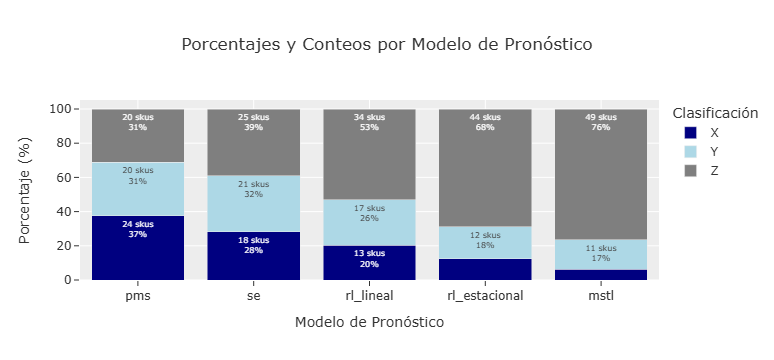

In [128]:
# x = 35
# y = 70
# graficar_xyz(df_final, x, y)

In [143]:
def crear_grafica_pronostico(df_mes_ceros, df_todos_pronosticos, df_pronosticos_mejor_modelo):
    # Obtener modelos únicos
    modelos_unicos = df_todos_pronosticos['MODELO'].unique()
    
    # Generar una paleta de colores en seaborn
    dark_colors = sns.color_palette("muted", n_colors=len(modelos_unicos)).as_hex()
    
    # Crear un diccionario para asignar colores a cada modelo
    color_mapping = {modelo: dark_colors[i] for i, modelo in enumerate(modelos_unicos)}

    # Lista de códigos únicos
    codigos_unicos = df_pronosticos_12_meses.index.unique(0)
    #codigos_unicos = df_mes_ceros["CODIGO"].unique()

    # Crear una figura
    fig = go.Figure()

    # Crear todas las trazas (una por cada Código y Modelo) y agregar al gráfico
    for codigo in codigos_unicos:
        # Filtrar df_mes por Codigo (para graficar la demanda)
        df_mes_filtrado = df_mes_ceros[df_mes_ceros["CODIGO"] == codigo]

        # Filtrar df_todos_pronosticos por Codigo (para graficar todos los pronósticos de modelos)
        df_todos_pronosticos_filtrado = df_todos_pronosticos[df_todos_pronosticos["CODIGO"] == codigo]

        # Filtrar df_pronosticos_mejor_modelo para obtener el mejor modelo de ese código
        df_pronosticos_filtrado = df_pronosticos_mejor_modelo[df_pronosticos_mejor_modelo["CODIGO"] == codigo]
        mejor_modelo = df_pronosticos_filtrado["MODELO"].values[0]  # Extraer el mejor modelo para ese código

        # Agregar la traza de DEMANDA para este código (inicialmente invisible)
        fig.add_trace(go.Scatter(
            x=df_mes_filtrado.index, 
            y=df_mes_filtrado["DEMANDA"], 
            mode='lines',
            name=f'{codigo}',
            line=dict(color='navy'),
            visible=False  # Inicialmente invisible
        ))

        # Agregar una traza para cada modelo en df_todos_pronosticos_filtrado
        for modelo in modelos_unicos:
            # Filtrar por el modelo específico dentro del código seleccionado
            df_modelo_filtrado = df_todos_pronosticos_filtrado[df_todos_pronosticos_filtrado["MODELO"] == modelo]

            # Determinar el estilo de la línea
            if modelo == mejor_modelo:
                line_style = dict(dash='solid', color='#FF4500', width=2.5)  # Continua para el mejor modelo
            else:
                line_style = dict(dash='dot', color=color_mapping[modelo])  # Punteada para los demás modelos

            # Agregar la traza de FORECAST de este modelo (inicialmente invisible)
            fig.add_trace(go.Scatter(
                x=df_modelo_filtrado.index, 
                y=df_modelo_filtrado["FORECAST"], 
                mode='lines',
                name=f'{modelo}',
                line=line_style,
                visible=False  # Inicialmente invisible
            ))

    # Crear botones para el dropdown del primer menú (Códigos)
    dropdown_buttons_codigo = []
    for i, codigo in enumerate(codigos_unicos):
        # Visibilidad de DEMANDA y todas las trazas de pronósticos para este código
        visibility = [False] * len(fig.data)  # Inicializar todas las trazas como invisibles

        # Mostrar DEMANDA
        visibility[i * (len(modelos_unicos) + 1)] = True  

        # Mostrar todas las trazas de los modelos para el código seleccionado
        for j in range(len(modelos_unicos)):
            visibility[i * (len(modelos_unicos) + 1) + j + 1] = True

        # Botón para seleccionar el código
        dropdown_buttons_codigo.append(
            dict(
                args=[{"visible": visibility}],  # Cambiar la visibilidad de las trazas
                label=str(codigo),  # Etiqueta del código
                method="update"
            )
        )

    # Mostrar la primera DEMANDA y todos los modelos del primer código por defecto
    fig.data[0].visible = True
    for j in range(len(modelos_unicos)):
        fig.data[j + 1].visible = True

    # Configurar el layout con el menú dropdown
    fig.update_layout(
        template="ggplot2",
        updatemenus=[
            # Menú desplegable para seleccionar el Código
            dict(
                buttons=dropdown_buttons_codigo,
                direction="down",
                showactive=True,
                x=-0.05, y=1.0,   # Posición del dropdown
                xanchor="right",
                yanchor="top"
            )
        ],
        title="Demanda vs Pronóstico por Código",
        xaxis_title="Fecha",
        yaxis_title="Demanda",
        showlegend=True,
        xaxis=dict(showgrid=True, gridcolor='lightgray'),
        yaxis=dict(showgrid=True, gridcolor='lightgray'),
        legend=dict(
            orientation="v",
            yanchor="middle",
            xanchor="left",
            x=1.05,
            y=0.5
        ),
        height=400,
        plot_bgcolor='#F0F0F0',  # Set the plot background color to a light gray
    )

    return fig

# Script de prueba

No se pronosticaran las siguientes referencias debido a que tienen muy pocos datos:
CODIGO
PT086    1
dtype: int64


Procesando SKUs: 100%|██████████| 44/44 [00:28<00:00,  1.54it/s]

Periodo de Evaluacion desde:
2023-12 hasta 2024-11
MAE% global: 28.63%
Sesgo% global: 12.29%
Score global: 40.93%
RMSE global: 11326.3


,LAG,MAE%,SESGO%,SCORE%
0,Lag_1,25.53%,8.00%,33.53%
1,Lag_2,29.96%,11.21%,41.17%
2,Lag_3,30.46%,12.62%,43.08%
3,Lag_4,29.86%,14.34%,44.20%
4,Lag_5,28.77%,15.80%,44.57%
5,Lag_6,27.72%,15.27%,42.99%


Periodo de Evaluacion desde:
2023-12 hasta 2024-11
MAE% global: 28.63%
Sesgo% global: 12.29%
Score global: 40.93%
RMSE global: 11326.3


,CODIGO,MAE%,SESGO%,SCORE%
3,PT005,17.30%,0.10%,17.40%
11,PT033,17.53%,0.72%,18.25%
42,PT082,9.34%,9.34%,18.68%
10,PT031,20.13%,0.71%,20.83%
9,PT026,21.20%,1.62%,22.82%
5,PT007,22.69%,-0.28%,22.97%
29,PT065,21.88%,1.35%,23.23%
12,PT034,18.38%,7.26%,25.63%
4,PT006,23.07%,5.55%,28.62%
2,PT004,24.23%,5.67%,29.90%


Procesando SKUs: 100%|██████████| 44/44 [00:04<00:00, 10.15it/s]

El sku PT083 no tiene suficientes datos para la fecha de corte 2024-10-01 00:00:00
Periodo de Evaluacion desde:
2023-12 hasta 2024-11
MAE% global: 30.88%
Sesgo% global: 15.42%
Score global: 46.30%
RMSE global: 11730.5


,LAG,MAE%,SESGO%,SCORE%
0,Lag_1,27.13%,10.33%,37.46%
1,Lag_2,30.90%,14.18%,45.08%
2,Lag_3,32.14%,15.69%,47.83%
3,Lag_4,32.33%,18.00%,50.33%
4,Lag_5,32.88%,19.75%,52.63%
5,Lag_6,32.00%,18.64%,50.64%


Periodo de Evaluacion desde:
2023-12 hasta 2024-11
MAE% global: 30.88%
Sesgo% global: 15.42%
Score global: 46.30%
RMSE global: 11730.5


,CODIGO,MAE%,SESGO%,SCORE%
11,PT033,17.32%,-0.10%,17.42%
42,PT082,9.59%,9.59%,19.18%
3,PT005,19.45%,2.69%,22.14%
9,PT026,23.08%,3.00%,26.08%
5,PT007,25.80%,0.41%,26.21%
10,PT031,22.47%,3.75%,26.22%
12,PT034,20.66%,5.91%,26.57%
29,PT065,23.36%,5.09%,28.45%
4,PT006,26.33%,4.98%,31.31%
39,PT079,17.66%,13.67%,31.33%


Procesando SKUs:  91%|█████████ | 40/44 [00:02<00:00, 14.54it/s]

Sin datos: SKU=PT078, Fecha=2024-09-01 00:00:00, Datos disponibles=3


Procesando SKUs: 100%|██████████| 44/44 [00:03<00:00, 14.36it/s]

Sin datos: SKU=PT082, Fecha=2024-09-01 00:00:00, Datos disponibles=3
Sin datos: SKU=PT083, Fecha=2024-10-01 00:00:00, Datos disponibles=1
Sin datos: SKU=PT083, Fecha=2024-11-01 00:00:00, Datos disponibles=2
Periodo de Evaluacion desde:
2023-12 hasta 2024-11
MAE% global: 33.96%
Sesgo% global: 11.69%
Score global: 45.65%
RMSE global: 13340.3


,LAG,MAE%,SESGO%,SCORE%
0,Lag_1,29.90%,10.68%,40.57%
1,Lag_2,33.58%,12.13%,45.71%
2,Lag_3,35.96%,12.32%,48.28%
3,Lag_4,36.24%,12.92%,49.16%
4,Lag_5,35.57%,12.61%,48.17%
5,Lag_6,34.52%,9.08%,43.60%


Periodo de Evaluacion desde:
2023-12 hasta 2024-11
MAE% global: 33.96%
Sesgo% global: 11.69%
Score global: 45.65%
RMSE global: 13340.3


,CODIGO,MAE%,SESGO%,SCORE%
13,PT035,19.14%,2.04%,21.19%
11,PT033,15.22%,-6.42%,21.64%
2,PT004,25.34%,-0.03%,25.37%
10,PT031,20.04%,-6.08%,26.13%
36,PT075,24.04%,4.12%,28.16%
37,PT076,24.01%,-4.69%,28.70%
12,PT034,21.59%,-9.29%,30.88%
26,PT056,17.43%,16.39%,33.82%
3,PT005,23.19%,-11.33%,34.52%
8,PT025,34.78%,-0.48%,35.25%


Periodo de Evaluacion desde:
2023-12 hasta 2024-11
MAE% global: 34.65%
Sesgo% global: 12.45%
Score global: 47.10%
RMSE global: 10421.0


,LAG,MAE%,SESGO%,SCORE%
0,Lag_1,32.65%,14.28%,46.93%
1,Lag_2,33.86%,13.89%,47.75%
2,Lag_3,34.59%,12.27%,46.86%
3,Lag_4,34.54%,12.47%,47.02%
4,Lag_5,35.89%,11.31%,47.20%
5,Lag_6,38.36%,8.33%,46.69%


Periodo de Evaluacion desde:
2023-12 hasta 2024-11
MAE% global: 34.65%
Sesgo% global: 12.45%
Score global: 47.10%
RMSE global: 10421.0


,CODIGO,MAE%,SESGO%,SCORE%
11,PT033,18.40%,3.79%,22.19%
12,PT034,22.10%,-3.02%,25.13%
13,PT035,20.16%,7.49%,27.65%
30,PT070,15.07%,15.07%,30.14%
29,PT066,26.15%,5.16%,31.31%
0,PT002,27.63%,6.02%,33.65%
9,PT026,31.90%,-2.88%,34.78%
8,PT025,35.77%,1.80%,37.56%
4,PT006,25.13%,-12.71%,37.84%
31,PT075,26.40%,16.07%,42.48%


Procesando SKUs: 100%|██████████| 44/44 [00:01<00:00, 31.20it/s]


Sin datos: SKU=PT083, Fecha=2024-11-01 00:00:00, Datos disponibles=2


Procesando SKUs: 100%|██████████| 44/44 [00:03<00:00, 14.41it/s]

Periodo de Evaluacion desde:
2024-03 hasta 2024-11
MAE% global: 24.76%
Sesgo% global: -0.03%
Score global: 24.79%
RMSE global: 8443.5


,LAG,MAE%,SESGO%,SCORE%
0,Lag_1,26.75%,2.78%,29.53%
1,Lag_2,26.01%,1.02%,27.03%
2,Lag_3,24.54%,-2.10%,26.65%
3,Lag_4,24.00%,-3.25%,27.25%
4,Lag_5,22.37%,-1.01%,23.38%
5,Lag_6,22.47%,1.23%,23.70%


Periodo de Evaluacion desde:
2024-03 hasta 2024-11
MAE% global: 24.76%
Sesgo% global: -0.03%
Score global: 24.79%
RMSE global: 8443.5


,CODIGO,MAE%,SESGO%,SCORE%
12,PT034,19.09%,-2.62%,21.70%
11,PT033,18.22%,-7.12%,25.35%
13,PT035,16.98%,11.33%,28.31%
4,PT006,25.16%,-3.82%,28.97%
6,PT020,18.08%,12.71%,30.79%
0,PT002,19.88%,12.42%,32.30%
5,PT007,22.95%,-12.72%,35.67%
9,PT026,27.14%,-10.31%,37.45%
2,PT004,35.85%,-4.22%,40.07%
10,PT031,23.48%,17.03%,40.51%


Procesando SKUs: 100%|██████████| 44/44 [00:01<00:00, 28.00it/s]


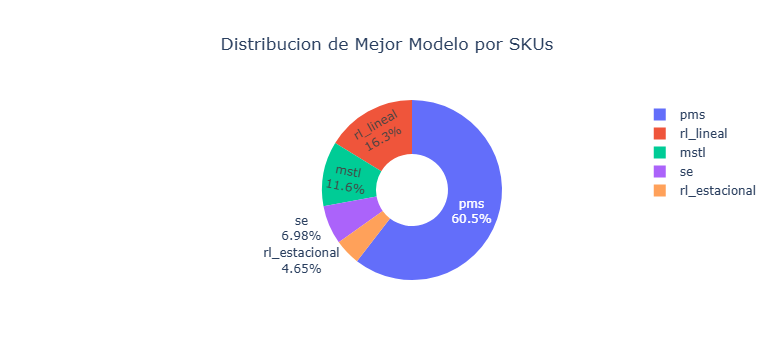

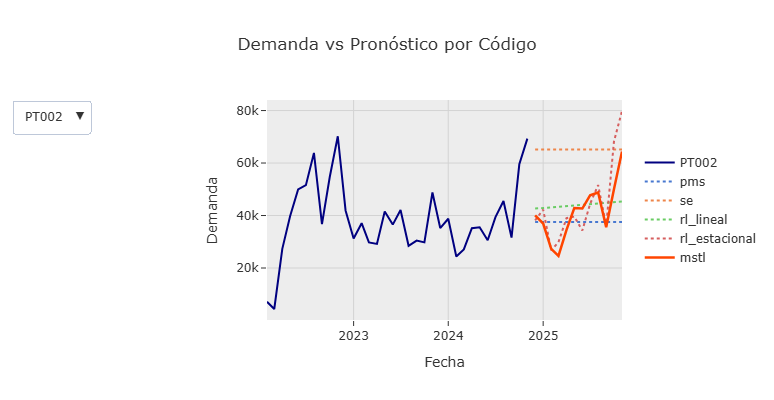

In [144]:
# Cargar data
ruta_demanda = r'dataset/historico_venta 2022_2024.xlsx'
df = cargar_data(ruta_demanda)

# Preprocesar data
df_vertical = convertir_a_df_vertical(df)
df_vertical_fecha = convertir_texto_a_fecha(df_vertical, meses)
df_resultado = eliminar_ceros_iniciales(df_vertical_fecha)
df_mes_cliente = preprocesar_tabla_2(df_resultado)

# Grafica 1: Demanda por Codigo - Cliente
#graficar_demanda_codigo_cliente(df_mes_cliente)

# Grafica 2: Demanda por Codigo Agregado
#df_mes_orig, reporte_codigos = agrupar_demanda(df_mes_cliente)
#graficar_demanda_codigo(df_mes_orig)

# Seleccionar tipo de Pronostico
opcion = opciones[1]
df_mes_orig, reporte_codigos = seleccionar_tipo_pronostico(opcion, df_mes_cliente)

# Reemplazar los Ceros por la mediana
df_mes_ceros = reemplazar_ceros(df_mes_orig)

# Grafica 3: Demanda con los ceros reemplazados
#graficar_demanda_codigo(df_mes_ceros)

# Definir limites sup e inf
sup = 0.98
inf = 0.02

# Definir n para el pronostico ingenuo
n = 6

# Imputar Outliers
df_mes, df_outliers = eliminar_outliers(df_mes_ceros, sup, inf, n)

# Grafica 4: Demanda sin Outliers
#graficar_demanda_codigo(df_mes)

# Grafica 5: Visualizacion de Ouliers imputados
#graficar_outliers_subplots(df_mes_ceros, sup=sup, inf=inf, n=n)

# Evaluar Modelos de Pronosticos de Serie de Tiempo
lista_skus = crear_lista_skus(df_mes) # Crear lista de skus
meses_a_pronosticar_evaluacion = 6 # Numero de meses a pronosticar para evaluar y seleccionar el modelo
periodo_max_evaluacion = 12 # Numero de periodos maximos de evaluacion de cada serie de tiempo
porc_eval = 0.35 # Porcentaje de meses para evaluar el modelo

# PMS
df_mejor_n, df_forecast_pms = evaluar_y_generar_pms(df_mes, df_mes_ceros, lista_skus, periodo_max_evaluacion, porc_eval, meses_a_pronosticar_evaluacion)

# Reportes de error PMS
grupo_mes_error_formato_pms, df_test_pms = kpi_error_lag(df_forecast_pms) # Reporte global
grupo_sku_error_formato_pms, rmse_sku_lag_pms, rmse_sku_mes_pms = kpi_error_sku(df_forecast_pms) # Reporte por sku

# Generar Pronosticos finales con PMS
meses_a_pronosticar_produccion = 12 # Numero de meses finales a pronosticar
df_forecast_final_pms = construir_pronostico_pms(df_mejor_n, df_mes, meses_a_pronosticar_produccion, 'pms')

# Suavizacion Exponencial
df_mejor_se,  df_forecast_se = encontrar_mejor_se(df_mes, df_mes_ceros, lista_skus, periodo_max_evaluacion, porc_eval, meses_a_pronosticar_evaluacion)

# Reportes de error SE
grupo_mes_error_formato_se, df_test_se = kpi_error_lag(df_forecast_se) # Reporte global
grupo_sku_error_formato_se, rmse_sku_lag_se, rmse_sku_mes_se = kpi_error_sku(df_forecast_se) # Reporte por sku

# Generar Pronosticos finales con SE
porc_eval = 0 # Porcentaje de Evaluacion se lleva a 0 para pronosticar
df_mejor_se_final,  df_forecast_final_se = encontrar_mejor_se(df_mes, df_mes_ceros, lista_skus, periodo_max_evaluacion, porc_eval, meses_a_pronosticar_produccion)
df_forecast_final_se = adicionar_nombre_modelo_serie_tiempo(df_forecast_final_se, 'se')

# Regresion lineal simple y "estacional"
porc_eval = 0.35
df_mejor_rl_lineal, df_mejor_rl_estacional, df_forecast_rl_lineal, df_forecast_rl_estacional = aplicar_regresion_lineal_simple(lista_skus, df_mes, df_mes_ceros, 
                                    periodo_max_evaluacion, porc_eval, 
                                    meses_a_pronosticar_evaluacion)

# Reportes error RL
grupo_mes_error_formato_rl_lineal, df_test_rl_lineal= kpi_error_lag(df_forecast_rl_lineal) # Reporte global RL simple
grupo_sku_error_formato_rl_lineal, rmse_sku_lag_rl_lineal, rmse_sku_mes_rl_lineal = kpi_error_sku(df_forecast_rl_lineal) # Reporte por sku RL simple
grupo_mes_error_formato_rl_estacional, df_test_rl_estacional= kpi_error_lag(df_forecast_rl_estacional) # Reporte global RL estacional
grupo_sku_error_formato_rl_estacional, rmse_sku_lag_rl_estacional, rmse_sku_mes_rl_estacional = kpi_error_sku(df_forecast_rl_estacional) # Reporte por sku RL estacional

# Generar Pronosticos finales con RL 
porc_eval = 0
df_final_mejor_rl_lineal, df_final_mejor_rl_estacional, df_forecast_final_rl_lineal, df_forecast_final_rl_estacional = aplicar_regresion_lineal_simple(lista_skus, df_mes, df_mes_ceros, 
                                    periodo_max_evaluacion, porc_eval, 
                                    meses_a_pronosticar_produccion)
df_forecast_final_rl_lineal = adicionar_nombre_modelo_serie_tiempo(df_forecast_final_rl_lineal, 'rl_lineal')
df_forecast_final_rl_estacional = adicionar_nombre_modelo_serie_tiempo(df_forecast_final_rl_estacional, 'rl_estacional')

# Modelo de descomposicion MSTL
porc_eval = 0.35
peso_ult_data = 0.08
df_mejor_mstl, df_forecast_mstl = aplicar_mstl(lista_skus, df_mes, df_mes_ceros, 
                                    periodo_max_evaluacion, porc_eval, 
                                    meses_a_pronosticar_evaluacion, peso_ult_data)
 # Reportes de error MSTL
grupo_mes_error_formato_mstl, df_test_mstl = kpi_error_lag(df_forecast_mstl) # Reporte golbal
grupo_sku_error_formato_mstl, rmse_sku_lag_mstl, rmse_sku_mes_mstl = kpi_error_sku(df_forecast_mstl) # Reporte por sku

# Generar Pronosticos finales con MSTL
porc_eval = 0
tabla_final_pronost, df_forecast_final_mstl = aplicar_mstl(lista_skus, df_mes, df_mes_ceros, 
                                    periodo_max_evaluacion, porc_eval, 
                                    meses_a_pronosticar_produccion, peso_ult_data)
df_forecast_final_mstl = adicionar_nombre_modelo_serie_tiempo(df_forecast_final_mstl, 'mstl')

# Crear reporte acumulado de errores de todos los modelos
modelos = ['pms', 'se', 'rl_lineal', 'rl_estacional', 'mstl']
reporte_error_skus = generar_reporte_error_skus(modelos)

# Grafica 6: Distribucion de merjor modelos por sku
df_minimos, df_final, reporte_error_skus = comparar_y_graficar_modelos(reporte_error_skus)

# Concatener todos los pronosticos finales generados
df_todos_pronosticos = concatenar_forecasts_pronosticos(modelos)

# Crear tabla final con pronosticos a 12 meses
df_pronosticos_mejor_modelo, df_pronosticos_12_meses = obtener_mejor_pronostico(df_minimos, df_todos_pronosticos)

# Grafica final demanda vs mejor pronostico
fig = crear_grafica_pronostico(df_mes, df_todos_pronosticos, df_pronosticos_mejor_modelo)
fig.show()